# GPL Paper Section 4.1.2 Experiment: Quadratic Hamiltonian with L1 Prior

This code attempts to learn 16D prior $J(x) = \|x\|_1$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian
$H(p) = \frac{1}{2}\|p\|_2^2$ (Using the method of characterization).
The LPN learns the function $\psi(y) = J^*(y) - \frac{1}{2}\|y\|_2^2$.
Training data uses samples $\{y_j,\psi(y_j)\}$ where $\psi(y_j) = \frac{1}{2}\|y_j\|_2^2 - S(y_j,1)$, and,
$S(y_j,1) = \min_{x \in \mathbb{R}^d} \{\frac{1}{2}\|x-y_j\|_2^2 + \|x\|_1\}$ (Moreau envelope of $J(x)=\|x\|_1$ at $t=1$).

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_4_1_2_quadratic_16D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [2]:
# Parameters
# --- Parameters for Sec 4.1.2 L1 Prior Experiment ---
dim_exp = 16  
data_points_exp = 30000 
iterations_exp_initial = 1 
iterations_exp_long = 500000 
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 100 


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers
#eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Section 4.1.2: L1 Prior Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)

def prox_l1_vec(y, t_lambda):
    """ Element-wise proximal operator of t_lambda*||x||_1 (soft-thresholding). """
    return np.sign(y) * np.maximum(np.abs(y) - t_lambda, 0)

def hjsol_true_quadratic_l1(y_points,n=1.0, t=1.0): # y_points is N x dim
    """
    Computes S(y, t=1) for J(x)=||x||_1.
    S(y, 1) = ||x||_1 + nt/2 }
    """
    t_moreau = 1.0
    prox_y = prox_l1_vec(y_points, t_moreau) # element-wise for N x dim
    s_values = np.sum(np.abs(prox_y), axis=1) +n * t/2 # L1 norm for each vector y_j 
    return s_values # N-dimensional array

def prior_true_quadratic_l1(y_points): # y_points is N x dim
    """ Computes the true prior J(y) = ||y||_1. """
    return np.sum(np.abs(y_points), axis=1) # N-dimensional array

def cvx_true_quadratic_l1(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = 0.5*||y||_2^2 - S(y, t=1) for J(x)=||x||_1.
    """
    s_y_1 = hjsol_true_quadratic_l1(y_points)
    psi_y = 0.5 * euclid_norm_sq(y_points) - s_y_1
    return psi_y # N-dimensional array

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est

def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_quadratic_l1(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_quadratic_l1(x1_0_points)
    x1_0_J_true = prior_true_quadratic_l1(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_quadratic_l1(x2_0_points)
        x2_0_J_true = prior_true_quadratic_l1(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=\\|x\\|_1$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_quadratic_l1(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, L1 Prior (Dim={dim}) ---")
    cross_sections_plots_quadratic_l1(model, a, spacing, INVERT_MODE, dim)



In [4]:

def exp_func(x, gamma):
    # Ensure x is a 1D tensor for vector_norm if it comes in as N x 1
    if x.ndim > 1 and x.shape[1] == 1:
        x = x.squeeze(1)
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim=-1)/ gamma) ** 2)) + 1.0

# --- Generate Training Data (using Moreau envelope target as per notebook) ---

In [5]:
# --- Generate Training Data ---
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))

cvx_samples_exp_np = cvx_true_quadratic_l1(y_j_exp_np)
cvx_samples_exp_np = cvx_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float()
cvx_samples_exp_tensor = torch.from_numpy(cvx_samples_exp_np).float()
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, cvx_samples_exp_tensor shape {cvx_samples_exp_tensor.shape}")
# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
cvx_samples_exp_tensor = cvx_samples_exp_tensor.to(device)

Generated training data: y_j_exp_tensor shape torch.Size([30000, 16]), cvx_samples_exp_tensor shape torch.Size([30000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L1 loss -- Train

In [7]:

print("--- Training LPN for J(x)=||x||_1 (Quadratic H) ---")
lpn_model_quad_l1 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_quad_l1 = torch.optim.Adam(lpn_model_quad_l1.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_quad_l1, optimizer_quad_l1, y_j_exp_tensor,cvx_samples_exp_tensor,loss_type=1,gamma_loss=None)

for g in optimizer_quad_l1.param_groups:
    g["lr"] = 1e-4 
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_quad_l1.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_quad_l1, optimizer_quad_l1, y_j_exp_tensor,cvx_samples_exp_tensor,loss_type=1,gamma_loss=None)

torch.save(lpn_model_quad_l1.state_dict(), os.path.join(MODEL_DIR, "QuadraticH_L1prior_l1.pth"))

--- Training LPN for J(x)=||x||_1 (Quadratic H) ---


iteration 0 loss 24.63384246826172
iteration 0 loss 11.764965057373047


iteration 500 loss 2.4762516021728516


iteration 1000 loss 2.3929853439331055


iteration 1500 loss 2.3053338527679443


iteration 2000 loss 2.163086414337158


iteration 2500 loss 1.852742075920105


iteration 3000 loss 0.9836645722389221


iteration 3500 loss 0.5729783773422241


iteration 4000 loss 0.5039871335029602


iteration 4500 loss 0.472514808177948


iteration 5000 loss 0.44964516162872314


iteration 5500 loss 0.43668270111083984


iteration 6000 loss 0.42280495166778564


iteration 6500 loss 0.41344764828681946


iteration 7000 loss 0.4072640538215637


iteration 7500 loss 0.3994791805744171


iteration 8000 loss 0.39442259073257446


iteration 8500 loss 0.3921314477920532


iteration 9000 loss 0.3858194351196289


iteration 9500 loss 0.3818608820438385


iteration 10000 loss 0.38174930214881897


iteration 10500 loss 0.37549909949302673


iteration 11000 loss 0.3728266656398773


iteration 11500 loss 0.36889851093292236


iteration 12000 loss 0.3659434914588928


iteration 12500 loss 0.3656073808670044


iteration 13000 loss 0.36559465527534485


iteration 13500 loss 0.3587445318698883


iteration 14000 loss 0.35706302523612976


iteration 14500 loss 0.35515138506889343


iteration 15000 loss 0.35263240337371826


iteration 15500 loss 0.3559143841266632


iteration 16000 loss 0.3531080186367035


iteration 16500 loss 0.3470294773578644


iteration 17000 loss 0.35025906562805176


iteration 17500 loss 0.3467973470687866


iteration 18000 loss 0.34743672609329224


iteration 18500 loss 0.3458671569824219


iteration 19000 loss 0.33936282992362976


iteration 19500 loss 0.33776742219924927


iteration 20000 loss 0.34116387367248535


iteration 20500 loss 0.33464452624320984


iteration 21000 loss 0.33711013197898865


iteration 21500 loss 0.3319777846336365


iteration 22000 loss 0.3316376805305481


iteration 22500 loss 0.3340202569961548


iteration 23000 loss 0.3324718773365021


iteration 23500 loss 0.3282453715801239


iteration 24000 loss 0.32605499029159546


iteration 24500 loss 0.32532674074172974


iteration 25000 loss 0.3233129680156708


iteration 25500 loss 0.32791462540626526


iteration 26000 loss 0.32480621337890625


iteration 26500 loss 0.3206639885902405


iteration 27000 loss 0.32473862171173096


iteration 27500 loss 0.3179015517234802


iteration 28000 loss 0.3176128566265106


iteration 28500 loss 0.31600409746170044


iteration 29000 loss 0.31963294744491577


iteration 29500 loss 0.3134859502315521


iteration 30000 loss 0.3189367353916168


iteration 30500 loss 0.31299537420272827


iteration 31000 loss 0.312715619802475


iteration 31500 loss 0.31599271297454834


iteration 32000 loss 0.31023284792900085


iteration 32500 loss 0.3144720792770386


iteration 33000 loss 0.3070344626903534


iteration 33500 loss 0.3115335702896118


iteration 34000 loss 0.30992767214775085


iteration 34500 loss 0.30743977427482605


iteration 35000 loss 0.3094261884689331


iteration 35500 loss 0.301859974861145


iteration 36000 loss 0.3027346134185791


iteration 36500 loss 0.3064771592617035


iteration 37000 loss 0.30191856622695923


iteration 37500 loss 0.30259597301483154


iteration 38000 loss 0.30357182025909424


iteration 38500 loss 0.3029356300830841


iteration 39000 loss 0.29638350009918213


iteration 39500 loss 0.3004288971424103


iteration 40000 loss 0.2944621741771698


iteration 40500 loss 0.2982325553894043


iteration 41000 loss 0.29364511370658875


iteration 41500 loss 0.29794058203697205


iteration 42000 loss 0.29665255546569824


iteration 42500 loss 0.28949862718582153


iteration 43000 loss 0.2897037863731384


iteration 43500 loss 0.29347720742225647


iteration 44000 loss 0.2868059277534485


iteration 44500 loss 0.29002800583839417


iteration 45000 loss 0.2876504361629486


iteration 45500 loss 0.29119905829429626


iteration 46000 loss 0.28363320231437683


iteration 46500 loss 0.28527721762657166


iteration 47000 loss 0.28974342346191406


iteration 47500 loss 0.2870869040489197


iteration 48000 loss 0.28727900981903076


iteration 48500 loss 0.27899909019470215


iteration 49000 loss 0.27837076783180237


iteration 49500 loss 0.2840630114078522


iteration 50000 loss 0.2830321788787842


iteration 50500 loss 0.28029149770736694


iteration 51000 loss 0.28182631731033325


iteration 51500 loss 0.2807280719280243


iteration 52000 loss 0.28067103028297424


iteration 52500 loss 0.272818386554718


iteration 53000 loss 0.27898430824279785


iteration 53500 loss 0.27212831377983093


iteration 54000 loss 0.2727562189102173


iteration 54500 loss 0.2742046117782593


iteration 55000 loss 0.2740955948829651


iteration 55500 loss 0.2696630358695984


iteration 56000 loss 0.26777639985084534


iteration 56500 loss 0.268648236989975


iteration 57000 loss 0.267302006483078


iteration 57500 loss 0.27013880014419556


iteration 58000 loss 0.2654019594192505


iteration 58500 loss 0.26594290137290955


iteration 59000 loss 0.2670624256134033


iteration 59500 loss 0.27005311846733093


iteration 60000 loss 0.26845628023147583


iteration 60500 loss 0.26460617780685425


iteration 61000 loss 0.26420342922210693


iteration 61500 loss 0.266886830329895


iteration 62000 loss 0.26606976985931396


iteration 62500 loss 0.2592812478542328


iteration 63000 loss 0.2621900141239166


iteration 63500 loss 0.26067888736724854


iteration 64000 loss 0.2633938789367676


iteration 64500 loss 0.26477351784706116


iteration 65000 loss 0.2636100649833679


iteration 65500 loss 0.2558826804161072


iteration 66000 loss 0.2553282678127289


iteration 66500 loss 0.25549185276031494


iteration 67000 loss 0.2617252767086029


iteration 67500 loss 0.25394389033317566


iteration 68000 loss 0.258741170167923


iteration 68500 loss 0.2537875175476074


iteration 69000 loss 0.2543981075286865


iteration 69500 loss 0.25300952792167664


iteration 70000 loss 0.25159114599227905


iteration 70500 loss 0.2565120756626129


iteration 71000 loss 0.25629356503486633


iteration 71500 loss 0.2541135847568512


iteration 72000 loss 0.25551530718803406


iteration 72500 loss 0.24831609427928925


iteration 73000 loss 0.25426530838012695


iteration 73500 loss 0.2547087073326111


iteration 74000 loss 0.2469276338815689


iteration 74500 loss 0.2473318725824356


iteration 75000 loss 0.25127723813056946


iteration 75500 loss 0.25178658962249756


iteration 76000 loss 0.25145700573921204


iteration 76500 loss 0.25099101662635803


iteration 77000 loss 0.2503957152366638


iteration 77500 loss 0.25242775678634644


iteration 78000 loss 0.2432570457458496


iteration 78500 loss 0.252398282289505


iteration 79000 loss 0.24942350387573242


iteration 79500 loss 0.24718351662158966


iteration 80000 loss 0.2504428029060364


iteration 80500 loss 0.24245698750019073


iteration 81000 loss 0.2461635172367096


iteration 81500 loss 0.24374762177467346


iteration 82000 loss 0.2468174546957016


iteration 82500 loss 0.2448994219303131


iteration 83000 loss 0.24041514098644257


iteration 83500 loss 0.24286536872386932


iteration 84000 loss 0.2420009821653366


iteration 84500 loss 0.24360479414463043


iteration 85000 loss 0.23693418502807617


iteration 85500 loss 0.23847158253192902


iteration 86000 loss 0.24056221544742584


iteration 86500 loss 0.24439960718154907


iteration 87000 loss 0.23531095683574677


iteration 87500 loss 0.23499122262001038


iteration 88000 loss 0.24196724593639374


iteration 88500 loss 0.2370264083147049


iteration 89000 loss 0.23396094143390656


iteration 89500 loss 0.24090979993343353


iteration 90000 loss 0.2394772171974182


iteration 90500 loss 0.2348671704530716


iteration 91000 loss 0.24016298353672028


iteration 91500 loss 0.2404726892709732


iteration 92000 loss 0.2329609990119934


iteration 92500 loss 0.23783548176288605


iteration 93000 loss 0.23303206264972687


iteration 93500 loss 0.23927712440490723


iteration 94000 loss 0.2328861504793167


iteration 94500 loss 0.23597213625907898


iteration 95000 loss 0.23328498005867004


iteration 95500 loss 0.2383408397436142


iteration 96000 loss 0.22884592413902283


iteration 96500 loss 0.2296973317861557


iteration 97000 loss 0.23002313077449799


iteration 97500 loss 0.2296920269727707


iteration 98000 loss 0.22824923694133759


iteration 98500 loss 0.23509016633033752


iteration 99000 loss 0.2321012020111084


iteration 99500 loss 0.23466090857982635


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.2278110831975937


iteration 100500 loss 0.22588860988616943


iteration 101000 loss 0.22563496232032776


iteration 101500 loss 0.225494384765625


iteration 102000 loss 0.22518637776374817


iteration 102500 loss 0.22512738406658173


iteration 103000 loss 0.22498750686645508


iteration 103500 loss 0.2248038500547409


iteration 104000 loss 0.2245679497718811


iteration 104500 loss 0.2245599329471588


iteration 105000 loss 0.22443166375160217


iteration 105500 loss 0.2242685854434967


iteration 106000 loss 0.22436246275901794


iteration 106500 loss 0.22398756444454193


iteration 107000 loss 0.2241075187921524


iteration 107500 loss 0.2240477204322815


iteration 108000 loss 0.22365455329418182


iteration 108500 loss 0.2235349416732788


iteration 109000 loss 0.22373802959918976


iteration 109500 loss 0.22371505200862885


iteration 110000 loss 0.2234792411327362


iteration 110500 loss 0.2232915461063385


iteration 111000 loss 0.2231835424900055


iteration 111500 loss 0.22341367602348328


iteration 112000 loss 0.22331516444683075


iteration 112500 loss 0.22311173379421234


iteration 113000 loss 0.22290831804275513


iteration 113500 loss 0.22304490208625793


iteration 114000 loss 0.22307249903678894


iteration 114500 loss 0.222940593957901


iteration 115000 loss 0.22262059152126312


iteration 115500 loss 0.22274509072303772


iteration 116000 loss 0.22279305756092072


iteration 116500 loss 0.22281187772750854


iteration 117000 loss 0.22238008677959442


iteration 117500 loss 0.22227177023887634


iteration 118000 loss 0.22242480516433716


iteration 118500 loss 0.22218504548072815


iteration 119000 loss 0.22224675118923187


iteration 119500 loss 0.2223493456840515


iteration 120000 loss 0.2223789393901825


iteration 120500 loss 0.22206199169158936


iteration 121000 loss 0.2218710482120514


iteration 121500 loss 0.22188231348991394


iteration 122000 loss 0.22230450809001923


iteration 122500 loss 0.22171910107135773


iteration 123000 loss 0.22210630774497986


iteration 123500 loss 0.2221527099609375


iteration 124000 loss 0.221925750374794


iteration 124500 loss 0.22206629812717438


iteration 125000 loss 0.22187435626983643


iteration 125500 loss 0.22200992703437805


iteration 126000 loss 0.22159868478775024


iteration 126500 loss 0.22128528356552124


iteration 127000 loss 0.22144316136837006


iteration 127500 loss 0.22175955772399902


iteration 128000 loss 0.22163449227809906


iteration 128500 loss 0.2210758924484253


iteration 129000 loss 0.22135482728481293


iteration 129500 loss 0.22141395509243011


iteration 130000 loss 0.22140006721019745


iteration 130500 loss 0.22120721638202667


iteration 131000 loss 0.2210930734872818


iteration 131500 loss 0.22114747762680054


iteration 132000 loss 0.22079749405384064


iteration 132500 loss 0.22102725505828857


iteration 133000 loss 0.22116918861865997


iteration 133500 loss 0.22112403810024261


iteration 134000 loss 0.22104883193969727


iteration 134500 loss 0.2207554429769516


iteration 135000 loss 0.22057732939720154


iteration 135500 loss 0.220418781042099


iteration 136000 loss 0.22067564725875854


iteration 136500 loss 0.2204836905002594


iteration 137000 loss 0.22036881744861603


iteration 137500 loss 0.2203853279352188


iteration 138000 loss 0.22064854204654694


iteration 138500 loss 0.2207057774066925


iteration 139000 loss 0.2203742116689682


iteration 139500 loss 0.22015367448329926


iteration 140000 loss 0.22012947499752045


iteration 140500 loss 0.2203190177679062


iteration 141000 loss 0.22022177278995514


iteration 141500 loss 0.22019486129283905


iteration 142000 loss 0.21991455554962158


iteration 142500 loss 0.21977126598358154


iteration 143000 loss 0.21972279250621796


iteration 143500 loss 0.22024698555469513


iteration 144000 loss 0.2196226269006729


iteration 144500 loss 0.22010758519172668


iteration 145000 loss 0.2198123335838318


iteration 145500 loss 0.21956442296504974


iteration 146000 loss 0.21986393630504608


iteration 146500 loss 0.21948763728141785


iteration 147000 loss 0.2195567637681961


iteration 147500 loss 0.21939717233181


iteration 148000 loss 0.21959945559501648


iteration 148500 loss 0.21928337216377258


iteration 149000 loss 0.2195776402950287


iteration 149500 loss 0.2196444869041443


iteration 150000 loss 0.21955716609954834


iteration 150500 loss 0.21977943181991577


iteration 151000 loss 0.2194458395242691


iteration 151500 loss 0.21943646669387817


iteration 152000 loss 0.21945449709892273


iteration 152500 loss 0.2194509357213974


iteration 153000 loss 0.21901735663414001


iteration 153500 loss 0.2194528579711914


iteration 154000 loss 0.21892234683036804


iteration 154500 loss 0.21878138184547424


iteration 155000 loss 0.2188110500574112


iteration 155500 loss 0.2189648300409317


iteration 156000 loss 0.218608096241951


iteration 156500 loss 0.21855123341083527


iteration 157000 loss 0.21905599534511566


iteration 157500 loss 0.21894854307174683


iteration 158000 loss 0.21905390918254852


iteration 158500 loss 0.21891437470912933


iteration 159000 loss 0.2184264361858368


iteration 159500 loss 0.2187947779893875


iteration 160000 loss 0.21859247982501984


iteration 160500 loss 0.2186080366373062


iteration 161000 loss 0.21863007545471191


iteration 161500 loss 0.21841095387935638


iteration 162000 loss 0.21849945187568665


iteration 162500 loss 0.21808072924613953


iteration 163000 loss 0.2180740237236023


iteration 163500 loss 0.21817158162593842


iteration 164000 loss 0.21854078769683838


iteration 164500 loss 0.21809612214565277


iteration 165000 loss 0.21793042123317719


iteration 165500 loss 0.21783477067947388


iteration 166000 loss 0.21819095313549042


iteration 166500 loss 0.21815048158168793


iteration 167000 loss 0.21813121438026428


iteration 167500 loss 0.2178242951631546


iteration 168000 loss 0.21802517771720886


iteration 168500 loss 0.21796871721744537


iteration 169000 loss 0.2176348716020584


iteration 169500 loss 0.21752944588661194


iteration 170000 loss 0.21754330396652222


iteration 170500 loss 0.21745918691158295


iteration 171000 loss 0.21802067756652832


iteration 171500 loss 0.21749292314052582


iteration 172000 loss 0.21753142774105072


iteration 172500 loss 0.21734118461608887


iteration 173000 loss 0.21777990460395813


iteration 173500 loss 0.21778640151023865


iteration 174000 loss 0.21764816343784332


iteration 174500 loss 0.21723408997058868


iteration 175000 loss 0.21728940308094025


iteration 175500 loss 0.21757695078849792


iteration 176000 loss 0.21730929613113403


iteration 176500 loss 0.21749597787857056


iteration 177000 loss 0.21755804121494293


iteration 177500 loss 0.2176228016614914


iteration 178000 loss 0.2171783596277237


iteration 178500 loss 0.21691851317882538


iteration 179000 loss 0.21745604276657104


iteration 179500 loss 0.21728454530239105


iteration 180000 loss 0.21704836189746857


iteration 180500 loss 0.2170427441596985


iteration 181000 loss 0.21699777245521545


iteration 181500 loss 0.21727846562862396


iteration 182000 loss 0.21677370369434357


iteration 182500 loss 0.2165721207857132


iteration 183000 loss 0.21688230335712433


iteration 183500 loss 0.21667194366455078


iteration 184000 loss 0.21683667600154877


iteration 184500 loss 0.2170180082321167


iteration 185000 loss 0.21638759970664978


iteration 185500 loss 0.21635113656520844


iteration 186000 loss 0.21692955493927002


iteration 186500 loss 0.21628578007221222


iteration 187000 loss 0.21690495312213898


iteration 187500 loss 0.21809612214565277


iteration 188000 loss 0.21625329554080963


iteration 188500 loss 0.21646647155284882


iteration 189000 loss 0.2165585160255432


iteration 189500 loss 0.2167385369539261


iteration 190000 loss 0.2164255827665329


iteration 190500 loss 0.2165057212114334


iteration 191000 loss 0.21633975207805634


iteration 191500 loss 0.2160865217447281


iteration 192000 loss 0.21634246408939362


iteration 192500 loss 0.2165098637342453


iteration 193000 loss 0.21627798676490784


iteration 193500 loss 0.21653717756271362


iteration 194000 loss 0.2162127047777176


iteration 194500 loss 0.21614480018615723


iteration 195000 loss 0.21576178073883057


iteration 195500 loss 0.21619746088981628


iteration 196000 loss 0.21599601209163666


iteration 196500 loss 0.21621501445770264


iteration 197000 loss 0.2161707878112793


iteration 197500 loss 0.2160625159740448


iteration 198000 loss 0.2159387320280075


iteration 198500 loss 0.21602125465869904


iteration 199000 loss 0.2154102474451065


iteration 199500 loss 0.2158396989107132


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.21537445485591888


iteration 200500 loss 0.21528306603431702


iteration 201000 loss 0.21525685489177704


iteration 201500 loss 0.21523654460906982


iteration 202000 loss 0.21522298455238342


iteration 202500 loss 0.2152048945426941


iteration 203000 loss 0.21520254015922546


iteration 203500 loss 0.21516887843608856


iteration 204000 loss 0.21515725553035736


iteration 204500 loss 0.21516543626785278


iteration 205000 loss 0.21513473987579346


iteration 205500 loss 0.21514534950256348


iteration 206000 loss 0.21512682735919952


iteration 206500 loss 0.2151191681623459


iteration 207000 loss 0.2150963544845581


iteration 207500 loss 0.21509666740894318


iteration 208000 loss 0.21508486568927765


iteration 208500 loss 0.21507421135902405


iteration 209000 loss 0.21507035195827484


iteration 209500 loss 0.21507778763771057


iteration 210000 loss 0.21505606174468994


iteration 210500 loss 0.2150716334581375


iteration 211000 loss 0.21504053473472595


iteration 211500 loss 0.21503353118896484


iteration 212000 loss 0.21502523124217987


iteration 212500 loss 0.21505582332611084


iteration 213000 loss 0.2150116264820099


iteration 213500 loss 0.21501047909259796


iteration 214000 loss 0.21502022445201874


iteration 214500 loss 0.2150079756975174


iteration 215000 loss 0.2149866819381714


iteration 215500 loss 0.21502380073070526


iteration 216000 loss 0.2149839848279953


iteration 216500 loss 0.2149682343006134


iteration 217000 loss 0.2149895876646042


iteration 217500 loss 0.21496351063251495


iteration 218000 loss 0.21498942375183105


iteration 218500 loss 0.21495655179023743


iteration 219000 loss 0.2149566411972046


iteration 219500 loss 0.2149435430765152


iteration 220000 loss 0.21496427059173584


iteration 220500 loss 0.21492119133472443


iteration 221000 loss 0.21492300927639008


iteration 221500 loss 0.21494360268115997


iteration 222000 loss 0.21490737795829773


iteration 222500 loss 0.2149192988872528


iteration 223000 loss 0.21490547060966492


iteration 223500 loss 0.21489156782627106


iteration 224000 loss 0.2149074822664261


iteration 224500 loss 0.21488024294376373


iteration 225000 loss 0.21488942205905914


iteration 225500 loss 0.2148764282464981


iteration 226000 loss 0.21489420533180237


iteration 226500 loss 0.21490156650543213


iteration 227000 loss 0.2148824781179428


iteration 227500 loss 0.21486705541610718


iteration 228000 loss 0.21489237248897552


iteration 228500 loss 0.21487975120544434


iteration 229000 loss 0.21488356590270996


iteration 229500 loss 0.21484661102294922


iteration 230000 loss 0.2148391306400299


iteration 230500 loss 0.2148377001285553


iteration 231000 loss 0.21484817564487457


iteration 231500 loss 0.21481339633464813


iteration 232000 loss 0.21482382714748383


iteration 232500 loss 0.21480999886989594


iteration 233000 loss 0.2148207724094391


iteration 233500 loss 0.21484661102294922


iteration 234000 loss 0.2147914469242096


iteration 234500 loss 0.21478872001171112


iteration 235000 loss 0.2148023098707199


iteration 235500 loss 0.2147790640592575


iteration 236000 loss 0.21480393409729004


iteration 236500 loss 0.21478869020938873


iteration 237000 loss 0.21477919816970825


iteration 237500 loss 0.21477419137954712


iteration 238000 loss 0.21477383375167847


iteration 238500 loss 0.2147788405418396


iteration 239000 loss 0.21475161612033844


iteration 239500 loss 0.2147855907678604


iteration 240000 loss 0.21475514769554138


iteration 240500 loss 0.2147706151008606


iteration 241000 loss 0.2147596776485443


iteration 241500 loss 0.21473802626132965


iteration 242000 loss 0.21477127075195312


iteration 242500 loss 0.21471376717090607


iteration 243000 loss 0.21472467482089996


iteration 243500 loss 0.21473431587219238


iteration 244000 loss 0.21471774578094482


iteration 244500 loss 0.21471381187438965


iteration 245000 loss 0.2146948277950287


iteration 245500 loss 0.21473366022109985


iteration 246000 loss 0.21470846235752106


iteration 246500 loss 0.21470795571804047


iteration 247000 loss 0.2147103250026703


iteration 247500 loss 0.2147051841020584


iteration 248000 loss 0.2146759182214737


iteration 248500 loss 0.21470069885253906


iteration 249000 loss 0.21468715369701385


iteration 249500 loss 0.2147091180086136


iteration 250000 loss 0.2146977186203003


iteration 250500 loss 0.21466800570487976


iteration 251000 loss 0.21471969783306122


iteration 251500 loss 0.2146395742893219


iteration 252000 loss 0.21464931964874268


iteration 252500 loss 0.21463489532470703


iteration 253000 loss 0.21468202769756317


iteration 253500 loss 0.21467845141887665


iteration 254000 loss 0.2146175354719162


iteration 254500 loss 0.21465596556663513


iteration 255000 loss 0.21460875868797302


iteration 255500 loss 0.21461482346057892


iteration 256000 loss 0.21465475857257843


iteration 256500 loss 0.2146598994731903


iteration 257000 loss 0.21459424495697021


iteration 257500 loss 0.21461385488510132


iteration 258000 loss 0.2145916074514389


iteration 258500 loss 0.2146039754152298


iteration 259000 loss 0.21459326148033142


iteration 259500 loss 0.2145957499742508


iteration 260000 loss 0.214574933052063


iteration 260500 loss 0.21459224820137024


iteration 261000 loss 0.21459636092185974


iteration 261500 loss 0.21458317339420319


iteration 262000 loss 0.21455572545528412


iteration 262500 loss 0.21457423269748688


iteration 263000 loss 0.21454618871212006


iteration 263500 loss 0.21460016071796417


iteration 264000 loss 0.2145688384771347


iteration 264500 loss 0.21458277106285095


iteration 265000 loss 0.21454164385795593


iteration 265500 loss 0.21456506848335266


iteration 266000 loss 0.21458010375499725


iteration 266500 loss 0.2145446538925171


iteration 267000 loss 0.21456317603588104


iteration 267500 loss 0.21455202996730804


iteration 268000 loss 0.21472758054733276


iteration 268500 loss 0.2145102620124817


iteration 269000 loss 0.21452675759792328


iteration 269500 loss 0.2145005762577057


iteration 270000 loss 0.21453900635242462


iteration 270500 loss 0.21449889242649078


iteration 271000 loss 0.21449324488639832


iteration 271500 loss 0.21448567509651184


iteration 272000 loss 0.2145356684923172


iteration 272500 loss 0.21449081599712372


iteration 273000 loss 0.2144889086484909


iteration 273500 loss 0.21451793611049652


iteration 274000 loss 0.21451854705810547


iteration 274500 loss 0.21445858478546143


iteration 275000 loss 0.21445885300636292


iteration 275500 loss 0.21446336805820465


iteration 276000 loss 0.2144698202610016


iteration 276500 loss 0.21446272730827332


iteration 277000 loss 0.21444547176361084


iteration 277500 loss 0.2144470363855362


iteration 278000 loss 0.2144802361726761


iteration 278500 loss 0.21444706618785858


iteration 279000 loss 0.21442748606204987


iteration 279500 loss 0.2144632190465927


iteration 280000 loss 0.21444454789161682


iteration 280500 loss 0.21445117890834808


iteration 281000 loss 0.21440814435482025


iteration 281500 loss 0.21443606913089752


iteration 282000 loss 0.21441689133644104


iteration 282500 loss 0.2144557684659958


iteration 283000 loss 0.21441274881362915


iteration 283500 loss 0.21442244946956635


iteration 284000 loss 0.21442630887031555


iteration 284500 loss 0.21443571150302887


iteration 285000 loss 0.21438828110694885


iteration 285500 loss 0.21439290046691895


iteration 286000 loss 0.21438206732273102


iteration 286500 loss 0.2144164890050888


iteration 287000 loss 0.214389830827713


iteration 287500 loss 0.21435703337192535


iteration 288000 loss 0.21435436606407166


iteration 288500 loss 0.21437804400920868


iteration 289000 loss 0.2143486589193344


iteration 289500 loss 0.21434654295444489


iteration 290000 loss 0.2143862396478653


iteration 290500 loss 0.2143651694059372


iteration 291000 loss 0.21436744928359985


iteration 291500 loss 0.21433010697364807


iteration 292000 loss 0.2143247425556183


iteration 292500 loss 0.21437975764274597


iteration 293000 loss 0.21431605517864227


iteration 293500 loss 0.21436767280101776


iteration 294000 loss 0.21431179344654083


iteration 294500 loss 0.21430839598178864


iteration 295000 loss 0.21435751020908356


iteration 295500 loss 0.21430569887161255


iteration 296000 loss 0.2143041342496872


iteration 296500 loss 0.21429884433746338


iteration 297000 loss 0.21428698301315308


iteration 297500 loss 0.2143445611000061


iteration 298000 loss 0.21428275108337402


iteration 298500 loss 0.21431174874305725


iteration 299000 loss 0.2142937183380127


iteration 299500 loss 0.21426942944526672


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.2142706960439682


iteration 300500 loss 0.2142602950334549


iteration 301000 loss 0.21425801515579224


iteration 301500 loss 0.21425588428974152


iteration 302000 loss 0.21425645053386688


iteration 302500 loss 0.21425361931324005


iteration 303000 loss 0.21425235271453857


iteration 303500 loss 0.21425072848796844


iteration 304000 loss 0.214253231883049


iteration 304500 loss 0.214248925447464


iteration 305000 loss 0.2142474204301834


iteration 305500 loss 0.21424967050552368


iteration 306000 loss 0.21424587070941925


iteration 306500 loss 0.21424385905265808


iteration 307000 loss 0.21424314379692078


iteration 307500 loss 0.21424463391304016


iteration 308000 loss 0.21424375474452972


iteration 308500 loss 0.21424101293087006


iteration 309000 loss 0.21424569189548492


iteration 309500 loss 0.21424102783203125


iteration 310000 loss 0.21424007415771484


iteration 310500 loss 0.21424254775047302


iteration 311000 loss 0.21423929929733276


iteration 311500 loss 0.21423809230327606


iteration 312000 loss 0.21423929929733276


iteration 312500 loss 0.2142384797334671


iteration 313000 loss 0.21423529088497162


iteration 313500 loss 0.21423491835594177


iteration 314000 loss 0.21424071490764618


iteration 314500 loss 0.214235320687294


iteration 315000 loss 0.21423448622226715


iteration 315500 loss 0.21423743665218353


iteration 316000 loss 0.21423564851284027


iteration 316500 loss 0.21423403918743134


iteration 317000 loss 0.21423199772834778


iteration 317500 loss 0.2142331749200821


iteration 318000 loss 0.21423649787902832


iteration 318500 loss 0.21423153579235077


iteration 319000 loss 0.2142307609319687


iteration 319500 loss 0.21423695981502533


iteration 320000 loss 0.21423038840293884


iteration 320500 loss 0.2142292708158493


iteration 321000 loss 0.2142357975244522


iteration 321500 loss 0.21422861516475677


iteration 322000 loss 0.21422681212425232


iteration 322500 loss 0.21422941982746124


iteration 323000 loss 0.21422602236270905


iteration 323500 loss 0.21422579884529114


iteration 324000 loss 0.21422506868839264


iteration 324500 loss 0.21422594785690308


iteration 325000 loss 0.21422454714775085


iteration 325500 loss 0.21422477066516876


iteration 326000 loss 0.21422399580478668


iteration 326500 loss 0.21422383189201355


iteration 327000 loss 0.2142239212989807


iteration 327500 loss 0.21422885358333588


iteration 328000 loss 0.21422377228736877


iteration 328500 loss 0.2142227590084076


iteration 329000 loss 0.21422424912452698


iteration 329500 loss 0.2142229676246643


iteration 330000 loss 0.2142215222120285


iteration 330500 loss 0.2142234593629837


iteration 331000 loss 0.21421964466571808


iteration 331500 loss 0.2142195701599121


iteration 332000 loss 0.21421875059604645


iteration 332500 loss 0.21422109007835388


iteration 333000 loss 0.21421822905540466


iteration 333500 loss 0.21421951055526733


iteration 334000 loss 0.21422003209590912


iteration 334500 loss 0.21421664953231812


iteration 335000 loss 0.21422529220581055


iteration 335500 loss 0.2142179012298584


iteration 336000 loss 0.21421699225902557


iteration 336500 loss 0.21422156691551208


iteration 337000 loss 0.21421658992767334


iteration 337500 loss 0.21421575546264648


iteration 338000 loss 0.21421422064304352


iteration 338500 loss 0.2142152339220047


iteration 339000 loss 0.21421660482883453


iteration 339500 loss 0.2142171710729599


iteration 340000 loss 0.21421262621879578


iteration 340500 loss 0.2142123281955719


iteration 341000 loss 0.21421289443969727


iteration 341500 loss 0.21421536803245544


iteration 342000 loss 0.21421754360198975


iteration 342500 loss 0.2142132669687271


iteration 343000 loss 0.21421217918395996


iteration 343500 loss 0.21421757340431213


iteration 344000 loss 0.21421173214912415


iteration 344500 loss 0.21421094238758087


iteration 345000 loss 0.21421174705028534


iteration 345500 loss 0.214212566614151


iteration 346000 loss 0.21421383321285248


iteration 346500 loss 0.21421058475971222


iteration 347000 loss 0.2142084687948227


iteration 347500 loss 0.21420736610889435


iteration 348000 loss 0.21420705318450928


iteration 348500 loss 0.21420815587043762


iteration 349000 loss 0.2142077535390854


iteration 349500 loss 0.2142091542482376


iteration 350000 loss 0.21420830488204956


iteration 350500 loss 0.21420826017856598


iteration 351000 loss 0.21420767903327942


iteration 351500 loss 0.21421226859092712


iteration 352000 loss 0.21420644223690033


iteration 352500 loss 0.21420562267303467


iteration 353000 loss 0.21421067416667938


iteration 353500 loss 0.2142041027545929


iteration 354000 loss 0.214207723736763


iteration 354500 loss 0.21420376002788544


iteration 355000 loss 0.21420767903327942


iteration 355500 loss 0.2142075151205063


iteration 356000 loss 0.21420176327228546


iteration 356500 loss 0.21420437097549438


iteration 357000 loss 0.21420511603355408


iteration 357500 loss 0.21420297026634216


iteration 358000 loss 0.2142072319984436


iteration 358500 loss 0.2142021507024765


iteration 359000 loss 0.21420130133628845


iteration 359500 loss 0.21420420706272125


iteration 360000 loss 0.214199960231781


iteration 360500 loss 0.21419914066791534


iteration 361000 loss 0.21420247852802277


iteration 361500 loss 0.21419817209243774


iteration 362000 loss 0.21419814229011536


iteration 362500 loss 0.21419957280158997


iteration 363000 loss 0.2141982913017273


iteration 363500 loss 0.21419693529605865


iteration 364000 loss 0.21419993042945862


iteration 364500 loss 0.2141987681388855


iteration 365000 loss 0.2142035961151123


iteration 365500 loss 0.21419745683670044


iteration 366000 loss 0.21419690549373627


iteration 366500 loss 0.21420009434223175


iteration 367000 loss 0.2141970545053482


iteration 367500 loss 0.2141953855752945


iteration 368000 loss 0.21419833600521088


iteration 368500 loss 0.21419572830200195


iteration 369000 loss 0.2141968309879303


iteration 369500 loss 0.21419505774974823


iteration 370000 loss 0.21419742703437805


iteration 370500 loss 0.2141997516155243


iteration 371000 loss 0.2141941487789154


iteration 371500 loss 0.214193195104599


iteration 372000 loss 0.21419844031333923


iteration 372500 loss 0.21419328451156616


iteration 373000 loss 0.2141910046339035


iteration 373500 loss 0.21419362723827362


iteration 374000 loss 0.21419037878513336


iteration 374500 loss 0.21418996155261993


iteration 375000 loss 0.21418994665145874


iteration 375500 loss 0.2141895890235901


iteration 376000 loss 0.21419093012809753


iteration 376500 loss 0.21418997645378113


iteration 377000 loss 0.21419215202331543


iteration 377500 loss 0.2141883820295334


iteration 378000 loss 0.21419154107570648


iteration 378500 loss 0.21419118344783783


iteration 379000 loss 0.21419063210487366


iteration 379500 loss 0.21418802440166473


iteration 380000 loss 0.21418854594230652


iteration 380500 loss 0.21419008076190948


iteration 381000 loss 0.21418924629688263


iteration 381500 loss 0.21419337391853333


iteration 382000 loss 0.21418701112270355


iteration 382500 loss 0.21418651938438416


iteration 383000 loss 0.2141915112733841


iteration 383500 loss 0.2141847014427185


iteration 384000 loss 0.21418417990207672


iteration 384500 loss 0.2141844481229782


iteration 385000 loss 0.21418358385562897


iteration 385500 loss 0.21418358385562897


iteration 386000 loss 0.21418270468711853


iteration 386500 loss 0.21418467164039612


iteration 387000 loss 0.21418192982673645


iteration 387500 loss 0.2141869217157364


iteration 388000 loss 0.2141849398612976


iteration 388500 loss 0.2141827791929245


iteration 389000 loss 0.21418297290802002


iteration 389500 loss 0.21418055891990662


iteration 390000 loss 0.21418170630931854


iteration 390500 loss 0.21418257057666779


iteration 391000 loss 0.21418757736682892


iteration 391500 loss 0.21418152749538422


iteration 392000 loss 0.21418091654777527


iteration 392500 loss 0.21418511867523193


iteration 393000 loss 0.21418063342571259


iteration 393500 loss 0.21417994797229767


iteration 394000 loss 0.21418219804763794


iteration 394500 loss 0.21417786180973053


iteration 395000 loss 0.21417805552482605


iteration 395500 loss 0.21417786180973053


iteration 396000 loss 0.21417656540870667


iteration 396500 loss 0.21417738497257233


iteration 397000 loss 0.21417586505413055


iteration 397500 loss 0.21417652070522308


iteration 398000 loss 0.2141752988100052


iteration 398500 loss 0.21417516469955444


iteration 399000 loss 0.21417829394340515


iteration 399500 loss 0.21417731046676636


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.21417562663555145


iteration 400500 loss 0.21417395770549774


iteration 401000 loss 0.214173823595047


iteration 401500 loss 0.21417376399040222


iteration 402000 loss 0.21417367458343506


iteration 402500 loss 0.2141735702753067


iteration 403000 loss 0.21417346596717834


iteration 403500 loss 0.21417354047298431


iteration 404000 loss 0.21417327225208282


iteration 404500 loss 0.2141733467578888


iteration 405000 loss 0.21417325735092163


iteration 405500 loss 0.2141731232404709


iteration 406000 loss 0.21417298913002014


iteration 406500 loss 0.21417294442653656


iteration 407000 loss 0.2141728550195694


iteration 407500 loss 0.214172825217247


iteration 408000 loss 0.21417275071144104


iteration 408500 loss 0.21417272090911865


iteration 409000 loss 0.21417266130447388


iteration 409500 loss 0.2141726166009903


iteration 410000 loss 0.2141725718975067


iteration 410500 loss 0.21417254209518433


iteration 411000 loss 0.21417269110679626


iteration 411500 loss 0.21417246758937836


iteration 412000 loss 0.21417240798473358


iteration 412500 loss 0.2141723930835724


iteration 413000 loss 0.21417236328125


iteration 413500 loss 0.2141723334789276


iteration 414000 loss 0.21417230367660522


iteration 414500 loss 0.21417222917079926


iteration 415000 loss 0.21417221426963806


iteration 415500 loss 0.21417219936847687


iteration 416000 loss 0.21417236328125


iteration 416500 loss 0.2141721397638321


iteration 417000 loss 0.21417236328125


iteration 417500 loss 0.2141720950603485


iteration 418000 loss 0.21417206525802612


iteration 418500 loss 0.21417205035686493


iteration 419000 loss 0.21417200565338135


iteration 419500 loss 0.21417197585105896


iteration 420000 loss 0.21417194604873657


iteration 420500 loss 0.21417191624641418


iteration 421000 loss 0.2141718864440918


iteration 421500 loss 0.2141718566417694


iteration 422000 loss 0.21417184174060822


iteration 422500 loss 0.21417181193828583


iteration 423000 loss 0.21417178213596344


iteration 423500 loss 0.21417206525802612


iteration 424000 loss 0.21417206525802612


iteration 424500 loss 0.21417167782783508


iteration 425000 loss 0.2141716629266739


iteration 425500 loss 0.2141716480255127


iteration 426000 loss 0.21417182683944702


iteration 426500 loss 0.21417158842086792


iteration 427000 loss 0.21417158842086792


iteration 427500 loss 0.21417155861854553


iteration 428000 loss 0.21417151391506195


iteration 428500 loss 0.21417146921157837


iteration 429000 loss 0.21417158842086792


iteration 429500 loss 0.2141718715429306


iteration 430000 loss 0.2141714245080948


iteration 430500 loss 0.2141713947057724


iteration 431000 loss 0.2141714096069336


iteration 431500 loss 0.21417135000228882


iteration 432000 loss 0.21417135000228882


iteration 432500 loss 0.21417130529880524


iteration 433000 loss 0.21417132019996643


iteration 433500 loss 0.21417129039764404


iteration 434000 loss 0.21417126059532166


iteration 434500 loss 0.21417157351970673


iteration 435000 loss 0.2141714245080948


iteration 435500 loss 0.21417121589183807


iteration 436000 loss 0.21417120099067688


iteration 436500 loss 0.2141716033220291


iteration 437000 loss 0.2141711562871933


iteration 437500 loss 0.21417135000228882


iteration 438000 loss 0.21417135000228882


iteration 438500 loss 0.21417106688022614


iteration 439000 loss 0.21417106688022614


iteration 439500 loss 0.21417105197906494


iteration 440000 loss 0.21417120099067688


iteration 440500 loss 0.21417102217674255


iteration 441000 loss 0.21417097747325897


iteration 441500 loss 0.21417097747325897


iteration 442000 loss 0.2141709327697754


iteration 442500 loss 0.2141709327697754


iteration 443000 loss 0.214170902967453


iteration 443500 loss 0.21417087316513062


iteration 444000 loss 0.21417087316513062


iteration 444500 loss 0.21417087316513062


iteration 445000 loss 0.21417087316513062


iteration 445500 loss 0.2141711264848709


iteration 446000 loss 0.21417076885700226


iteration 446500 loss 0.21417075395584106


iteration 447000 loss 0.21417073905467987


iteration 447500 loss 0.214170902967453


iteration 448000 loss 0.21417079865932465


iteration 448500 loss 0.2141706496477127


iteration 449000 loss 0.2141706794500351


iteration 449500 loss 0.21417148411273956


iteration 450000 loss 0.21417061984539032


iteration 450500 loss 0.2141708880662918


iteration 451000 loss 0.21417059004306793


iteration 451500 loss 0.21417057514190674


iteration 452000 loss 0.21417057514190674


iteration 452500 loss 0.21417054533958435


iteration 453000 loss 0.21417054533958435


iteration 453500 loss 0.21417050063610077


iteration 454000 loss 0.21417050063610077


iteration 454500 loss 0.2141704559326172


iteration 455000 loss 0.214170441031456


iteration 455500 loss 0.2141704112291336


iteration 456000 loss 0.2141704112291336


iteration 456500 loss 0.2141703963279724


iteration 457000 loss 0.2141706794500351


iteration 457500 loss 0.21417036652565002


iteration 458000 loss 0.21417035162448883


iteration 458500 loss 0.21417029201984406


iteration 459000 loss 0.21417027711868286


iteration 459500 loss 0.2141706347465515


iteration 460000 loss 0.21417087316513062


iteration 460500 loss 0.21417023241519928


iteration 461000 loss 0.21417021751403809


iteration 461500 loss 0.21417047083377838


iteration 462000 loss 0.21417047083377838


iteration 462500 loss 0.2141701728105545


iteration 463000 loss 0.21417014300823212


iteration 463500 loss 0.21417011320590973


iteration 464000 loss 0.21417008340358734


iteration 464500 loss 0.21417060494422913


iteration 465000 loss 0.214170441031456


iteration 465500 loss 0.21417006850242615


iteration 466000 loss 0.21417005360126495


iteration 466500 loss 0.21417005360126495


iteration 467000 loss 0.21417002379894257


iteration 467500 loss 0.21417002379894257


iteration 468000 loss 0.21416999399662018


iteration 468500 loss 0.21416999399662018


iteration 469000 loss 0.21417051553726196


iteration 469500 loss 0.2141704112291336


iteration 470000 loss 0.2141699343919754


iteration 470500 loss 0.21417129039764404


iteration 471000 loss 0.21417011320590973


iteration 471500 loss 0.21416990458965302


iteration 472000 loss 0.21416988968849182


iteration 472500 loss 0.21416985988616943


iteration 473000 loss 0.21416985988616943


iteration 473500 loss 0.21416984498500824


iteration 474000 loss 0.21416980028152466


iteration 474500 loss 0.21416980028152466


iteration 475000 loss 0.21416975557804108


iteration 475500 loss 0.21416975557804108


iteration 476000 loss 0.21416974067687988


iteration 476500 loss 0.2141697257757187


iteration 477000 loss 0.21417002379894257


iteration 477500 loss 0.2141696959733963


iteration 478000 loss 0.2141696661710739


iteration 478500 loss 0.21416965126991272


iteration 479000 loss 0.21416975557804108


iteration 479500 loss 0.21416963636875153


iteration 480000 loss 0.21416977047920227


iteration 480500 loss 0.21416959166526794


iteration 481000 loss 0.21416959166526794


iteration 481500 loss 0.21416956186294556


iteration 482000 loss 0.21416953206062317


iteration 482500 loss 0.21416954696178436


iteration 483000 loss 0.21416975557804108


iteration 483500 loss 0.2141696959733963


iteration 484000 loss 0.21416985988616943


iteration 484500 loss 0.2141694724559784


iteration 485000 loss 0.2141694575548172


iteration 485500 loss 0.214169442653656


iteration 486000 loss 0.21416941285133362


iteration 486500 loss 0.21416939795017242


iteration 487000 loss 0.21416936814785004


iteration 487500 loss 0.21416999399662018


iteration 488000 loss 0.21416956186294556


iteration 488500 loss 0.21416935324668884


iteration 489000 loss 0.21416933834552765


iteration 489500 loss 0.21416932344436646


iteration 490000 loss 0.21416930854320526


iteration 490500 loss 0.21416927874088287


iteration 491000 loss 0.21416926383972168


iteration 491500 loss 0.21416927874088287


iteration 492000 loss 0.2141692340373993


iteration 492500 loss 0.2141692042350769


iteration 493000 loss 0.21416917443275452


iteration 493500 loss 0.21416917443275452


iteration 494000 loss 0.21416915953159332


iteration 494500 loss 0.21416914463043213


iteration 495000 loss 0.21416914463043213


iteration 495500 loss 0.21416912972927094


iteration 496000 loss 0.21416909992694855


iteration 496500 loss 0.21416911482810974


iteration 497000 loss 0.21416908502578735


iteration 497500 loss 0.21416905522346497


iteration 498000 loss 0.21417035162448883


iteration 498500 loss 0.21416901051998138


iteration 499000 loss 0.21416901051998138


iteration 499500 loss 0.2141689658164978


L1 loss -- Plot


--- Plotting Cross Sections for Quadratic H, L1 Prior (Dim=16) ---
loss -7.086891174316406


loss -108.18276977539062


loss -188.97113037109375


loss -258.72076416015625


loss -317.9228820800781


loss -366.51678466796875


loss -404.91082763671875


loss -434.31549072265625


loss -456.3169250488281


loss -472.4040222167969


loss -483.79266357421875


loss -491.46923828125


loss -496.2895812988281


loss -499.03765869140625


loss -500.4183349609375


loss -501.0085754394531


loss -501.21429443359375


loss -501.269775390625


loss -501.280517578125


loss -501.28192138671875


loss -501.28204345703125


loss -501.28204345703125


loss -501.28204345703125


loss -501.28204345703125


loss -501.28204345703125


loss -501.28204345703125


loss -501.2820129394531


loss -501.28204345703125


loss -501.28204345703125


loss -501.28204345703125


loss -501.28204345703125


loss -501.28204345703125


loss -501.28204345703125


loss -501.28204345703125


loss -501.28204345703125


loss -501.28204345703125


loss -501.28204345703125


loss -501.28204345703125


loss -501.28204345703125


loss -501.28204345703125


final mse:  3.8770744947846936e-10
max, min: 5.773238 -6.0031314
loss -7.086891174316406


loss -106.98606872558594


loss -184.80374145507812


loss -250.9823455810547


loss -306.2563171386719


loss -350.74176025390625


loss -385.3240966796875


loss -411.58441162109375


loss -431.21435546875


loss -445.64935302734375


loss -456.00457763671875


loss -463.1470031738281


loss -467.7911376953125


loss -470.5673522949219


loss -472.0456237792969


loss -472.71868896484375


loss -472.96734619140625


loss -473.037109375


loss -473.05084228515625


loss -473.05255126953125


loss -473.05267333984375


loss -473.05267333984375


loss -473.05267333984375


loss -473.05267333984375


loss -473.05267333984375


loss -473.05267333984375


loss -473.05267333984375


loss -473.05267333984375


loss -473.05267333984375


loss -473.05267333984375


loss -473.05267333984375


loss -473.05267333984375


loss -473.05267333984375


loss -473.05267333984375


loss -473.05267333984375


loss -473.05267333984375


loss -473.05267333984375


loss -473.05267333984375


loss -473.05267333984375


loss -473.05267333984375


final mse:  3.1580160708699623e-10
max, min: 5.974166 -5.9113884


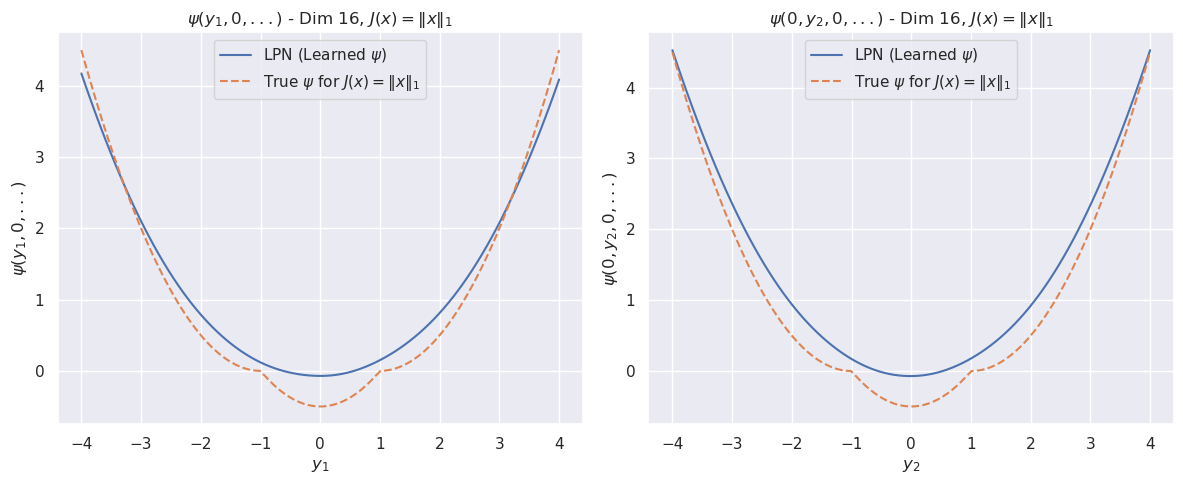

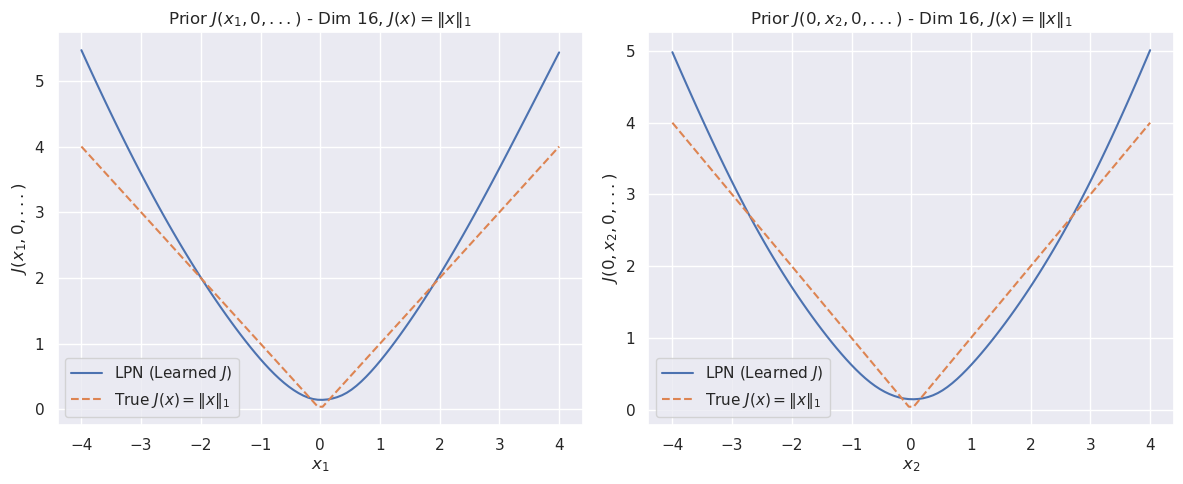

In [8]:
# L1 loss -- Plot
plot_all_quadratic_l1(lpn_model_quad_l1, a_exp, spacing, INVERT_MODE, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

psi_x_k = lpn_model_quad_l1.scalar(x_k_tensor)

y_k_tensor = lpn_model_quad_l1(x_k_tensor)

inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

tensor([[-0.3498,  0.8594, -2.4326,  ...,  1.9812, -2.2773,  0.6397],
        [-0.5023,  0.3717, -1.6921,  ...,  1.4676, -1.7836, -0.5700],
        [ 2.4129,  0.1491,  0.8470,  ..., -0.1023,  1.8706, -1.2253],
        ...,
        [-1.2854, -0.1260,  1.3922,  ...,  2.3275, -2.0003, -1.2955],
        [ 0.9760, -0.1694,  1.7527,  ..., -2.2763, -0.6483,  0.8049],
        [ 2.0255, -0.7221, -0.2864,  ..., -1.9259,  0.9756, -0.2402]],
       device='cuda:0')

In [10]:
# --- Step 3: Train 2nd LPN ---
print("\n--- Training Second LPN for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=1, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")


--- Training Second LPN for Concave Quadratic Prior ---
iteration 0 loss 26.85672950744629
iteration 0 loss 21.55298614501953


iteration 500 loss 11.766714096069336


iteration 1000 loss 7.113574981689453


iteration 1500 loss 2.4222280979156494


iteration 2000 loss 0.8514906167984009


iteration 2500 loss 0.4727882742881775


iteration 3000 loss 0.3367265462875366


iteration 3500 loss 0.26225489377975464


iteration 4000 loss 0.29581665992736816


iteration 4500 loss 0.19292742013931274


iteration 5000 loss 0.17638830840587616


iteration 5500 loss 0.16022063791751862


iteration 6000 loss 0.14438168704509735


iteration 6500 loss 0.12909650802612305


iteration 7000 loss 0.1146032065153122


iteration 7500 loss 0.10073510557413101


iteration 8000 loss 0.09505157917737961


iteration 8500 loss 0.09086927026510239


iteration 9000 loss 0.08618894219398499


iteration 9500 loss 0.08100833743810654


iteration 10000 loss 0.0753045454621315


iteration 10500 loss 0.06895051896572113


iteration 11000 loss 0.06545225530862808


iteration 11500 loss 0.06397919356822968


iteration 12000 loss 0.06227577477693558


iteration 12500 loss 0.0602184534072876


iteration 13000 loss 0.05772929638624191


iteration 13500 loss 0.054726287722587585


iteration 14000 loss 0.05110160633921623


iteration 14500 loss 0.04676734283566475


iteration 15000 loss 0.04499237984418869


iteration 15500 loss 0.04401112347841263


iteration 16000 loss 0.042879488319158554


iteration 16500 loss 0.04155197739601135


iteration 17000 loss 0.04001620411872864


iteration 17500 loss 0.038273267447948456


iteration 18000 loss 0.03634553402662277


iteration 18500 loss 0.03476640582084656


iteration 19000 loss 0.033892467617988586


iteration 19500 loss 0.033273838460445404


iteration 20000 loss 0.03254552558064461


iteration 20500 loss 0.03168858587741852


iteration 21000 loss 0.030675344169139862


iteration 21500 loss 0.030548159033060074


iteration 22000 loss 0.029307901859283447


iteration 22500 loss 0.02896372601389885


iteration 23000 loss 0.028551623225212097


iteration 23500 loss 0.028054533526301384


iteration 24000 loss 0.027456609532237053


iteration 24500 loss 0.026742439717054367


iteration 25000 loss 0.0265070591121912


iteration 25500 loss 0.026293376460671425


iteration 26000 loss 0.026052771136164665


iteration 26500 loss 0.025759020820260048


iteration 27000 loss 0.025398191064596176


iteration 27500 loss 0.024955421686172485


iteration 28000 loss 0.024417810142040253


iteration 28500 loss 0.024197550490498543


iteration 29000 loss 0.024014312773942947


iteration 29500 loss 0.023808341473340988


iteration 30000 loss 0.02355528436601162


iteration 30500 loss 0.02324218489229679


iteration 31000 loss 0.022855134680867195


iteration 31500 loss 0.022641496732831


iteration 32000 loss 0.022498006001114845


iteration 32500 loss 0.022343076765537262


iteration 33000 loss 0.022152168676257133


iteration 33500 loss 0.021914493292570114


iteration 34000 loss 0.02161945030093193


iteration 34500 loss 0.5195387601852417


iteration 35000 loss 0.021195434033870697


iteration 35500 loss 0.021079787984490395


iteration 36000 loss 0.020951855927705765


iteration 36500 loss 0.02079445868730545


iteration 37000 loss 0.02059829980134964


iteration 37500 loss 0.020354289561510086


iteration 38000 loss 0.020053375512361526


iteration 38500 loss 0.019993856549263


iteration 39000 loss 0.019896602258086205


iteration 39500 loss 0.019793741405010223


iteration 40000 loss 0.01966789737343788


iteration 40500 loss 0.019510746002197266


iteration 41000 loss 0.019314266741275787


iteration 41500 loss 0.01907079666852951


iteration 42000 loss 0.018943674862384796


iteration 42500 loss 0.018831385299563408


iteration 43000 loss 0.018708650022745132


iteration 43500 loss 0.018556896597146988


iteration 44000 loss 0.018367204815149307


iteration 44500 loss 0.018263086676597595


iteration 45000 loss 0.01815652661025524


iteration 45500 loss 0.018080297857522964


iteration 46000 loss 0.01799336075782776


iteration 46500 loss 0.017885876819491386


iteration 47000 loss 0.017751365900039673


iteration 47500 loss 0.01758589781820774


iteration 48000 loss 0.017488347366452217


iteration 48500 loss 0.017392847687005997


iteration 49000 loss 0.017309725284576416


iteration 49500 loss 0.017209529876708984


iteration 50000 loss 0.0170843955129385


iteration 50500 loss 0.01692785695195198


iteration 51000 loss 0.016868900507688522


iteration 51500 loss 0.01679411716759205


iteration 52000 loss 0.016732720658183098


iteration 52500 loss 0.01666107214987278


iteration 53000 loss 0.01657193712890148


iteration 53500 loss 0.016459759324789047


iteration 54000 loss 0.016319146379828453


iteration 54500 loss 0.016253633424639702


iteration 55000 loss 0.016165131703019142


iteration 55500 loss 0.016102775931358337


iteration 56000 loss 0.016031691804528236


iteration 56500 loss 0.01594368927180767


iteration 57000 loss 0.01583315245807171


iteration 57500 loss 0.015694668516516685


iteration 58000 loss 0.01567920669913292


iteration 58500 loss 0.015623760409653187


iteration 59000 loss 0.015571118332445621


iteration 59500 loss 0.015508431009948254


iteration 60000 loss 0.01543029211461544


iteration 60500 loss 0.015332141891121864


iteration 61000 loss 0.015210929326713085


iteration 61500 loss 0.015183812938630581


iteration 62000 loss 0.015123248100280762


iteration 62500 loss 0.015076179057359695


iteration 63000 loss 0.015023277141153812


iteration 63500 loss 0.014958309940993786


iteration 64000 loss 0.014876949600875378


iteration 64500 loss 0.014774961397051811


iteration 65000 loss 0.014731698669493198


iteration 65500 loss 0.014673625119030476


iteration 66000 loss 0.014606868848204613


iteration 66500 loss 0.014523948542773724


iteration 67000 loss 0.014420089311897755


iteration 67500 loss 0.01441043708473444


iteration 68000 loss 0.014361804351210594


iteration 68500 loss 0.014321232214570045


iteration 69000 loss 0.0142749585211277


iteration 69500 loss 0.014218027703464031


iteration 70000 loss 0.014146783389151096


iteration 70500 loss 0.014057885855436325


iteration 71000 loss 0.01403272245079279


iteration 71500 loss 0.013984755612909794


iteration 72000 loss 0.013936047442257404


iteration 72500 loss 0.013876709155738354


iteration 73000 loss 0.013802514411509037


iteration 73500 loss 0.013789712451398373


iteration 74000 loss 0.013733837753534317


iteration 74500 loss 0.01369745284318924


iteration 75000 loss 0.013658571057021618


iteration 75500 loss 0.013611376285552979


iteration 76000 loss 0.013552348129451275


iteration 76500 loss 0.013478383421897888


iteration 77000 loss 0.01347055658698082


iteration 77500 loss 0.01342125702649355


iteration 78000 loss 0.013387787155807018


iteration 78500 loss 0.013352250680327415


iteration 79000 loss 0.013309319503605366


iteration 79500 loss 0.013255681842565536


iteration 80000 loss 0.01319222804158926


iteration 80500 loss 0.013180088251829147


iteration 81000 loss 0.013136631809175014


iteration 81500 loss 0.01310523971915245


iteration 82000 loss 0.013070833869278431


iteration 82500 loss 0.013028755784034729


iteration 83000 loss 0.01297600194811821


iteration 83500 loss 0.012909621931612492


iteration 84000 loss 0.012909233570098877


iteration 84500 loss 0.012872396968305111


iteration 85000 loss 0.01284120324999094


iteration 85500 loss 0.012805553153157234


iteration 86000 loss 0.01276151929050684


iteration 86500 loss 0.012706423178315163


iteration 87000 loss 0.012703643180429935


iteration 87500 loss 0.012651313096284866


iteration 88000 loss 0.012621885165572166


iteration 88500 loss 0.012592101469635963


iteration 89000 loss 0.012556378729641438


iteration 89500 loss 0.012511689215898514


iteration 90000 loss 0.01245538517832756


iteration 90500 loss 0.012435885146260262


iteration 91000 loss 0.012396466918289661


iteration 91500 loss 0.012360705994069576


iteration 92000 loss 0.012317722663283348


iteration 92500 loss 0.01226385310292244


iteration 93000 loss 0.012260857038199902


iteration 93500 loss 0.012224748730659485


iteration 94000 loss 0.012196565046906471


iteration 94500 loss 0.012164883315563202


iteration 95000 loss 0.01212587021291256


iteration 95500 loss 0.012077096849679947


iteration 96000 loss 0.012081709690392017


iteration 96500 loss 0.012036584317684174


iteration 97000 loss 0.01201077550649643


iteration 97500 loss 0.011985620483756065


iteration 98000 loss 0.01195597555488348


iteration 98500 loss 0.011919114738702774


iteration 99000 loss 0.011872971430420876


iteration 99500 loss 0.01187488529831171


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.011834871955215931


iteration 100500 loss 0.011831807903945446


iteration 101000 loss 0.011828100308775902


iteration 101500 loss 0.011823651380836964


iteration 102000 loss 0.01181833166629076


iteration 102500 loss 0.011811940930783749


iteration 103000 loss 0.011804195120930672


iteration 103500 loss 0.011794711463153362


iteration 104000 loss 0.011782979592680931


iteration 104500 loss 0.011768302880227566


iteration 105000 loss 0.011749784462153912


iteration 105500 loss 0.01172632910311222


iteration 106000 loss 0.01169658824801445


iteration 106500 loss 0.011658849194645882


iteration 107000 loss 0.011611150577664375


iteration 107500 loss 0.011732952669262886


iteration 108000 loss 0.011542133055627346


iteration 108500 loss 0.011526652611792088


iteration 109000 loss 0.011506887152791023


iteration 109500 loss 0.01148166786879301


iteration 110000 loss 0.011449545621871948


iteration 110500 loss 0.01140879187732935


iteration 111000 loss 0.011357602663338184


iteration 111500 loss 0.011327270418405533


iteration 112000 loss 0.011315354146063328


iteration 112500 loss 0.011300298385322094


iteration 113000 loss 0.011281092651188374


iteration 113500 loss 0.011256637051701546


iteration 114000 loss 0.011225572787225246


iteration 114500 loss 0.011186301708221436


iteration 115000 loss 0.011137093417346478


iteration 115500 loss 0.011107019148766994


iteration 116000 loss 0.0110899917781353


iteration 116500 loss 0.011068331077694893


iteration 117000 loss 0.01104080118238926


iteration 117500 loss 0.011005915701389313


iteration 118000 loss 0.010961863212287426


iteration 118500 loss 0.010923201218247414


iteration 119000 loss 0.010913041420280933


iteration 119500 loss 0.010900893248617649


iteration 120000 loss 0.010885423049330711


iteration 120500 loss 0.010865687392652035


iteration 121000 loss 0.01084055844694376


iteration 121500 loss 0.010808656923472881


iteration 122000 loss 0.010768434032797813


iteration 122500 loss 0.010729341767728329


iteration 123000 loss 0.010719608515501022


iteration 123500 loss 0.010708330199122429


iteration 124000 loss 0.010693950578570366


iteration 124500 loss 0.010675597935914993


iteration 125000 loss 0.010652236640453339


iteration 125500 loss 0.010622536763548851


iteration 126000 loss 0.01058503333479166


iteration 126500 loss 0.010546696372330189


iteration 127000 loss 0.010537249967455864


iteration 127500 loss 0.010526924394071102


iteration 128000 loss 0.010513738729059696


iteration 128500 loss 0.010496902279555798


iteration 129000 loss 0.01047543529421091


iteration 129500 loss 0.010448145680129528


iteration 130000 loss 0.01041360478848219


iteration 130500 loss 0.010402425192296505


iteration 131000 loss 0.010361669585108757


iteration 131500 loss 0.010350948199629784


iteration 132000 loss 0.010337255895137787


iteration 132500 loss 0.010319788008928299


iteration 133000 loss 0.010297521948814392


iteration 133500 loss 0.010269218124449253


iteration 134000 loss 0.010233446955680847


iteration 134500 loss 0.010205051861703396


iteration 135000 loss 0.010196435265243053


iteration 135500 loss 0.010185794904828072


iteration 136000 loss 0.010172206908464432


iteration 136500 loss 0.010154876857995987


iteration 137000 loss 0.01013278029859066


iteration 137500 loss 0.010104765184223652


iteration 138000 loss 0.010069458745419979


iteration 138500 loss 0.010044672526419163


iteration 139000 loss 0.010036680847406387


iteration 139500 loss 0.01002663467079401


iteration 140000 loss 0.010013816878199577


iteration 140500 loss 0.00999746099114418


iteration 141000 loss 0.009976623579859734


iteration 141500 loss 0.00995015911757946


iteration 142000 loss 0.009916715323925018


iteration 142500 loss 0.009890973567962646


iteration 143000 loss 0.009883522987365723


iteration 143500 loss 0.009874561801552773


iteration 144000 loss 0.009863127022981644


iteration 144500 loss 0.009848522953689098


iteration 145000 loss 0.009829903952777386


iteration 145500 loss 0.009806230664253235


iteration 146000 loss 0.009776259772479534


iteration 146500 loss 0.009745936840772629


iteration 147000 loss 0.00973616261035204


iteration 147500 loss 0.009724188596010208


iteration 148000 loss 0.009708899073302746


iteration 148500 loss 0.009689408354461193


iteration 149000 loss 0.009664589539170265


iteration 149500 loss 0.009633153676986694


iteration 150000 loss 0.009614291600883007


iteration 150500 loss 0.009607396088540554


iteration 151000 loss 0.009598827920854092


iteration 151500 loss 0.009587875567376614


iteration 152000 loss 0.009573874063789845


iteration 152500 loss 0.009556014090776443


iteration 153000 loss 0.009533299133181572


iteration 153500 loss 0.00950455293059349


iteration 154000 loss 0.009476348757743835


iteration 154500 loss 0.009465999901294708


iteration 155000 loss 0.009453128091990948


iteration 155500 loss 0.00943670328706503


iteration 156000 loss 0.009415763430297375


iteration 156500 loss 0.009389161132276058


iteration 157000 loss 0.009360823780298233


iteration 157500 loss 0.009352690540254116


iteration 158000 loss 0.009344268590211868


iteration 158500 loss 0.009333522990345955


iteration 159000 loss 0.009319799020886421


iteration 159500 loss 0.009302282705903053


iteration 160000 loss 0.009279988706111908


iteration 160500 loss 0.009251788258552551


iteration 161000 loss 0.009233614429831505


iteration 161500 loss 0.009227565489709377


iteration 162000 loss 0.009220169857144356


iteration 162500 loss 0.009210717864334583


iteration 163000 loss 0.009198643267154694


iteration 163500 loss 0.009183233603835106


iteration 164000 loss 0.009163596667349339


iteration 164500 loss 0.009138728491961956


iteration 165000 loss 0.009114266373217106


iteration 165500 loss 0.00910811685025692


iteration 166000 loss 0.009101289324462414


iteration 166500 loss 0.009092568419873714


iteration 167000 loss 0.00908142700791359


iteration 167500 loss 0.009067203849554062


iteration 168000 loss 0.009049051441252232


iteration 168500 loss 0.00902603566646576


iteration 169000 loss 0.009502318687736988


iteration 169500 loss 0.008992448449134827


iteration 170000 loss 0.008985522203147411


iteration 170500 loss 0.008976680226624012


iteration 171000 loss 0.00896537397056818


iteration 171500 loss 0.008950947783887386


iteration 172000 loss 0.008932550437748432


iteration 172500 loss 0.008909287862479687


iteration 173000 loss 0.008886930532753468


iteration 173500 loss 0.008880645968019962


iteration 174000 loss 0.008873152546584606


iteration 174500 loss 0.008863577619194984


iteration 175000 loss 0.008851339109241962


iteration 175500 loss 0.008835737593472004


iteration 176000 loss 0.008815889246761799


iteration 176500 loss 0.008790821768343449


iteration 177000 loss 0.008777535520493984


iteration 177500 loss 0.00877227634191513


iteration 178000 loss 0.00876571238040924


iteration 178500 loss 0.008757318370044231


iteration 179000 loss 0.008746588602662086


iteration 179500 loss 0.008732877671718597


iteration 180000 loss 0.008715429343283176


iteration 180500 loss 0.008693353272974491


iteration 181000 loss 0.008672412484884262


iteration 181500 loss 0.008666832000017166


iteration 182000 loss 0.008661061525344849


iteration 182500 loss 0.008653685450553894


iteration 183000 loss 0.008644253015518188


iteration 183500 loss 0.00863219890743494


iteration 184000 loss 0.008616822771728039


iteration 184500 loss 0.008597278036177158


iteration 185000 loss 0.008572634309530258


iteration 185500 loss 0.008565706200897694


iteration 186000 loss 0.008560460060834885


iteration 186500 loss 0.00855383649468422


iteration 187000 loss 0.008545374497771263


iteration 187500 loss 0.008534552529454231


iteration 188000 loss 0.008520733565092087


iteration 188500 loss 0.00850321352481842


iteration 189000 loss 0.008480990305542946


iteration 189500 loss 0.00846679788082838


iteration 190000 loss 0.008461974561214447


iteration 190500 loss 0.008456075564026833


iteration 191000 loss 0.00844852440059185


iteration 191500 loss 0.008438877761363983


iteration 192000 loss 0.008426555432379246


iteration 192500 loss 0.008410848677158356


iteration 193000 loss 0.008390981703996658


iteration 193500 loss 0.008370374329388142


iteration 194000 loss 0.008363371714949608


iteration 194500 loss 0.008357062004506588


iteration 195000 loss 0.008348999544978142


iteration 195500 loss 0.00833869632333517


iteration 196000 loss 0.008325562812387943


iteration 196500 loss 0.008308842778205872


iteration 197000 loss 0.008287720382213593


iteration 197500 loss 0.008270613849163055


iteration 198000 loss 0.008265518583357334


iteration 198500 loss 0.00825937744230032


iteration 199000 loss 0.008251535706222057


iteration 199500 loss 0.008241523988544941


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.008228765800595284


iteration 200500 loss 0.008227127604186535


iteration 201000 loss 0.008225047029554844


iteration 201500 loss 0.00822239089757204


iteration 202000 loss 0.008219009265303612


iteration 202500 loss 0.008214710280299187


iteration 203000 loss 0.008209272287786007


iteration 203500 loss 0.008202414028346539


iteration 204000 loss 0.008193828165531158


iteration 204500 loss 0.008183185011148453


iteration 205000 loss 0.008170152083039284


iteration 205500 loss 0.008154434151947498


iteration 206000 loss 0.008135834708809853


iteration 206500 loss 0.008117187768220901


iteration 207000 loss 0.008099587634205818


iteration 207500 loss 0.008081669919192791


iteration 208000 loss 0.008063851855695248


iteration 208500 loss 0.008046145550906658


iteration 209000 loss 0.00802859291434288


iteration 209500 loss 0.008012142032384872


iteration 210000 loss 0.007995198480784893


iteration 210500 loss 0.007979461923241615


iteration 211000 loss 0.007962631992995739


iteration 211500 loss 0.00794640276581049


iteration 212000 loss 0.007930326275527477


iteration 212500 loss 0.007913821376860142


iteration 213000 loss 0.007897826842963696


iteration 213500 loss 0.007881018333137035


iteration 214000 loss 0.007864842191338539


iteration 214500 loss 0.00785019900649786


iteration 215000 loss 0.007834897376596928


iteration 215500 loss 0.00781941693276167


iteration 216000 loss 0.007804836146533489


iteration 216500 loss 0.007788707502186298


iteration 217000 loss 0.007775506470352411


iteration 217500 loss 0.007759842090308666


iteration 218000 loss 0.007745362352579832


iteration 218500 loss 0.00772993266582489


iteration 219000 loss 0.007715311367064714


iteration 219500 loss 0.0076997363939881325


iteration 220000 loss 0.007685441989451647


iteration 220500 loss 0.007670356426388025


iteration 221000 loss 0.007655685301870108


iteration 221500 loss 0.007640249095857143


iteration 222000 loss 0.007625343278050423


iteration 222500 loss 0.007610733155161142


iteration 223000 loss 0.007595499977469444


iteration 223500 loss 0.007582669612020254


iteration 224000 loss 0.007567477412521839


iteration 224500 loss 0.007554251700639725


iteration 225000 loss 0.0075390953570604324


iteration 225500 loss 0.00752525357529521


iteration 226000 loss 0.007510652765631676


iteration 226500 loss 0.007495683152228594


iteration 227000 loss 0.007482875604182482


iteration 227500 loss 0.007467979099601507


iteration 228000 loss 0.0074562616646289825


iteration 228500 loss 0.0074423253536224365


iteration 229000 loss 0.007429222110658884


iteration 229500 loss 0.007415777537971735


iteration 230000 loss 0.007402520626783371


iteration 230500 loss 0.007390242535620928


iteration 231000 loss 0.007375846616923809


iteration 231500 loss 0.007363251876085997


iteration 232000 loss 0.007349251303821802


iteration 232500 loss 0.00733672920614481


iteration 233000 loss 0.007323034107685089


iteration 233500 loss 0.0073110563680529594


iteration 234000 loss 0.007296876050531864


iteration 234500 loss 0.007285922300070524


iteration 235000 loss 0.007273022551089525


iteration 235500 loss 0.007260120939463377


iteration 236000 loss 0.007247372530400753


iteration 236500 loss 0.007234486751258373


iteration 237000 loss 0.00722180400043726


iteration 237500 loss 0.0072089447639882565


iteration 238000 loss 0.007196012418717146


iteration 238500 loss 0.007183480076491833


iteration 239000 loss 0.0071701835840940475


iteration 239500 loss 0.007157531101256609


iteration 240000 loss 0.007144392468035221


iteration 240500 loss 0.007131070829927921


iteration 241000 loss 0.007118577137589455


iteration 241500 loss 0.007106339558959007


iteration 242000 loss 0.007093688938766718


iteration 242500 loss 0.007081707939505577


iteration 243000 loss 0.007068754639476538


iteration 243500 loss 0.007056937087327242


iteration 244000 loss 0.007044235710054636


iteration 244500 loss 0.007032614201307297


iteration 245000 loss 0.0070203752256929874


iteration 245500 loss 0.007009448483586311


iteration 246000 loss 0.006996629759669304


iteration 246500 loss 0.0069844089448452


iteration 247000 loss 0.006973356008529663


iteration 247500 loss 0.006961875595152378


iteration 248000 loss 0.006950040813535452


iteration 248500 loss 0.006939164362847805


iteration 249000 loss 0.006926761474460363


iteration 249500 loss 0.006915202364325523


iteration 250000 loss 0.006903789006173611


iteration 250500 loss 0.006892537698149681


iteration 251000 loss 0.006881092209368944


iteration 251500 loss 0.006870693992823362


iteration 252000 loss 0.006858432665467262


iteration 252500 loss 0.006847134325653315


iteration 253000 loss 0.006835798732936382


iteration 253500 loss 0.00682448223233223


iteration 254000 loss 0.006813507527112961


iteration 254500 loss 0.006802508607506752


iteration 255000 loss 0.006791247520595789


iteration 255500 loss 0.0067803761921823025


iteration 256000 loss 0.006769157946109772


iteration 256500 loss 0.006758439354598522


iteration 257000 loss 0.006747343577444553


iteration 257500 loss 0.0067376382648944855


iteration 258000 loss 0.006726106628775597


iteration 258500 loss 0.006716433446854353


iteration 259000 loss 0.006705825682729483


iteration 259500 loss 0.006694906856864691


iteration 260000 loss 0.006684654392302036


iteration 260500 loss 0.006673275027424097


iteration 261000 loss 0.006662264466285706


iteration 261500 loss 0.006651982665061951


iteration 262000 loss 0.00664111552760005


iteration 262500 loss 0.006630498915910721


iteration 263000 loss 0.006619176361709833


iteration 263500 loss 0.006608990486711264


iteration 264000 loss 0.006597909610718489


iteration 264500 loss 0.006587390322238207


iteration 265000 loss 0.006577302236109972


iteration 265500 loss 0.006567368749529123


iteration 266000 loss 0.006556596141308546


iteration 266500 loss 0.0065468596294522285


iteration 267000 loss 0.006536007858812809


iteration 267500 loss 0.006526571698486805


iteration 268000 loss 0.006515522487461567


iteration 268500 loss 0.006507181562483311


iteration 269000 loss 0.006497251335531473


iteration 269500 loss 0.006487187463790178


iteration 270000 loss 0.006478617899119854


iteration 270500 loss 0.006468401290476322


iteration 271000 loss 0.006458161398768425


iteration 271500 loss 0.006447384133934975


iteration 272000 loss 0.006437873467803001


iteration 272500 loss 0.006427453365176916


iteration 273000 loss 0.0064178393222391605


iteration 273500 loss 0.006407661829143763


iteration 274000 loss 0.006397948134690523


iteration 274500 loss 0.006387937348335981


iteration 275000 loss 0.006378056015819311


iteration 275500 loss 0.0063684917986392975


iteration 276000 loss 0.006358788814395666


iteration 276500 loss 0.006349069066345692


iteration 277000 loss 0.006339350249618292


iteration 277500 loss 0.006329942494630814


iteration 278000 loss 0.006320528220385313


iteration 278500 loss 0.006310857366770506


iteration 279000 loss 0.00630176579579711


iteration 279500 loss 0.006291753146797419


iteration 280000 loss 0.006282413378357887


iteration 280500 loss 0.006273099221289158


iteration 281000 loss 0.006265082862228155


iteration 281500 loss 0.0062555051408708096


iteration 282000 loss 0.006246357224881649


iteration 282500 loss 0.006236956920474768


iteration 283000 loss 0.006227998528629541


iteration 283500 loss 0.006219399627298117


iteration 284000 loss 0.006209455896168947


iteration 284500 loss 0.006201199255883694


iteration 285000 loss 0.006191379856318235


iteration 285500 loss 0.006182804238051176


iteration 286000 loss 0.006173065397888422


iteration 286500 loss 0.006164452526718378


iteration 287000 loss 0.0061547039076685905


iteration 287500 loss 0.006146777421236038


iteration 288000 loss 0.006137768737971783


iteration 288500 loss 0.006128920242190361


iteration 289000 loss 0.00612063892185688


iteration 289500 loss 0.006110935006290674


iteration 290000 loss 0.00610316451638937


iteration 290500 loss 0.006093933247029781


iteration 291000 loss 0.006085485685616732


iteration 291500 loss 0.006076635327190161


iteration 292000 loss 0.006067876238375902


iteration 292500 loss 0.006059526465833187


iteration 293000 loss 0.006050162948668003


iteration 293500 loss 0.006042962893843651


iteration 294000 loss 0.00603433046489954


iteration 294500 loss 0.006025651469826698


iteration 295000 loss 0.006017854902893305


iteration 295500 loss 0.006008577067404985


iteration 296000 loss 0.006000810768455267


iteration 296500 loss 0.005992084741592407


iteration 297000 loss 0.0059838127344846725


iteration 297500 loss 0.005975892301648855


iteration 298000 loss 0.005966671742498875


iteration 298500 loss 0.005959211383014917


iteration 299000 loss 0.005950437393039465


iteration 299500 loss 0.005942443385720253


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.005934338551014662


iteration 300500 loss 0.005933382548391819


iteration 301000 loss 0.005932270549237728


iteration 301500 loss 0.005930991843342781


iteration 302000 loss 0.005929540377110243


iteration 302500 loss 0.005927916616201401


iteration 303000 loss 0.0059261503629386425


iteration 303500 loss 0.005924265831708908


iteration 304000 loss 0.005922276992350817


iteration 304500 loss 0.005920208990573883


iteration 305000 loss 0.005918062292039394


iteration 305500 loss 0.0059158760122954845


iteration 306000 loss 0.005913659930229187


iteration 306500 loss 0.005911439191550016


iteration 307000 loss 0.0059092384763062


iteration 307500 loss 0.005907047539949417


iteration 308000 loss 0.0059048766270279884


iteration 308500 loss 0.0059027173556387424


iteration 309000 loss 0.005900566466152668


iteration 309500 loss 0.005898427218198776


iteration 310000 loss 0.005896297749131918


iteration 310500 loss 0.0058941771276295185


iteration 311000 loss 0.005892064888030291


iteration 311500 loss 0.005889959167689085


iteration 312000 loss 0.005887863226234913


iteration 312500 loss 0.005885769613087177


iteration 313000 loss 0.005883684381842613


iteration 313500 loss 0.005881607066839933


iteration 314000 loss 0.005879535805433989


iteration 314500 loss 0.00587746687233448


iteration 315000 loss 0.005875408183783293


iteration 315500 loss 0.005873352289199829


iteration 316000 loss 0.005871303379535675


iteration 316500 loss 0.005869259592145681


iteration 317000 loss 0.00586721720173955


iteration 317500 loss 0.005865184590220451


iteration 318000 loss 0.005863151513040066


iteration 318500 loss 0.0058611310087144375


iteration 319000 loss 0.005859110504388809


iteration 319500 loss 0.005857095587998629


iteration 320000 loss 0.005855086725205183


iteration 320500 loss 0.005853079259395599


iteration 321000 loss 0.005851080175489187


iteration 321500 loss 0.005849084351211786


iteration 322000 loss 0.005847086664289236


iteration 322500 loss 0.005845102481544018


iteration 323000 loss 0.005843114107847214


iteration 323500 loss 0.0058411345817148685


iteration 324000 loss 0.005839160177856684


iteration 324500 loss 0.005837184842675924


iteration 325000 loss 0.0058352150954306126


iteration 325500 loss 0.005833250004798174


iteration 326000 loss 0.005831287708133459


iteration 326500 loss 0.005829327739775181


iteration 327000 loss 0.0058273752219974995


iteration 327500 loss 0.005825417581945658


iteration 328000 loss 0.005823469255119562


iteration 328500 loss 0.005821524187922478


iteration 329000 loss 0.005819582846015692


iteration 329500 loss 0.005817641969770193


iteration 330000 loss 0.00581570528447628


iteration 330500 loss 0.005813770927488804


iteration 331000 loss 0.005811838898807764


iteration 331500 loss 0.005809910129755735


iteration 332000 loss 0.0058079855516552925


iteration 332500 loss 0.005806061439216137


iteration 333000 loss 0.005804144777357578


iteration 333500 loss 0.005802227184176445


iteration 334000 loss 0.005800314247608185


iteration 334500 loss 0.005798403173685074


iteration 335000 loss 0.005796491634100676


iteration 335500 loss 0.005794590339064598


iteration 336000 loss 0.005792682990431786


iteration 336500 loss 0.005790783558040857


iteration 337000 loss 0.005788884591311216


iteration 337500 loss 0.005786989349871874


iteration 338000 loss 0.005785094108432531


iteration 338500 loss 0.005783203057944775


iteration 339000 loss 0.005781315267086029


iteration 339500 loss 0.005779428873211145


iteration 340000 loss 0.00577754620462656


iteration 340500 loss 0.00577566446736455


iteration 341000 loss 0.005773784592747688


iteration 341500 loss 0.005771907977759838


iteration 342000 loss 0.005770036019384861


iteration 342500 loss 0.005768161732703447


iteration 343000 loss 0.005766295362263918


iteration 343500 loss 0.005764427594840527


iteration 344000 loss 0.005762564484030008


iteration 344500 loss 0.005760699510574341


iteration 345000 loss 0.005758845247328281


iteration 345500 loss 0.005756985396146774


iteration 346000 loss 0.005755133926868439


iteration 346500 loss 0.005753279663622379


iteration 347000 loss 0.005751429125666618


iteration 347500 loss 0.005749582313001156


iteration 348000 loss 0.00574773782864213


iteration 348500 loss 0.0057458942756056786


iteration 349000 loss 0.005744050722569227


iteration 349500 loss 0.005742211360484362


iteration 350000 loss 0.005740372929722071


iteration 350500 loss 0.005738539155572653


iteration 351000 loss 0.00573670445010066


iteration 351500 loss 0.005734873469918966


iteration 352000 loss 0.0057330443523824215


iteration 352500 loss 0.005731216166168451


iteration 353000 loss 0.005729387514293194


iteration 353500 loss 0.0057275681756436825


iteration 354000 loss 0.005725742783397436


iteration 354500 loss 0.005723921582102776


iteration 355000 loss 0.00572210643440485


iteration 355500 loss 0.0057202912867069244


iteration 356000 loss 0.005718477535992861


iteration 356500 loss 0.005716664716601372


iteration 357000 loss 0.005714856553822756


iteration 357500 loss 0.005713045131415129


iteration 358000 loss 0.005711238365620375


iteration 358500 loss 0.005709436256438494


iteration 359000 loss 0.005707630421966314


iteration 359500 loss 0.005705828778445721


iteration 360000 loss 0.005704035516828299


iteration 360500 loss 0.005702235270291567


iteration 361000 loss 0.005700436886399984


iteration 361500 loss 0.0056986440904438496


iteration 362000 loss 0.00569685036316514


iteration 362500 loss 0.005695059429854155


iteration 363000 loss 0.005693272687494755


iteration 363500 loss 0.005691483151167631


iteration 364000 loss 0.005689701531082392


iteration 364500 loss 0.005687920842319727


iteration 365000 loss 0.005686137825250626


iteration 365500 loss 0.005684355273842812


iteration 366000 loss 0.005682577379047871


iteration 366500 loss 0.00568079948425293


iteration 367000 loss 0.005679023452103138


iteration 367500 loss 0.005677251145243645


iteration 368000 loss 0.005675478372722864


iteration 368500 loss 0.005673709325492382


iteration 369000 loss 0.005671937949955463


iteration 369500 loss 0.005670169834047556


iteration 370000 loss 0.005668407306075096


iteration 370500 loss 0.0056666419841349125


iteration 371000 loss 0.005664880387485027


iteration 371500 loss 0.005663120653480291


iteration 372000 loss 0.005661358125507832


iteration 372500 loss 0.005659603048115969


iteration 373000 loss 0.005657847970724106


iteration 373500 loss 0.005656091496348381


iteration 374000 loss 0.005654343403875828


iteration 374500 loss 0.005652591120451689


iteration 375000 loss 0.005650845356285572


iteration 375500 loss 0.005649097729474306


iteration 376000 loss 0.005647351499646902


iteration 376500 loss 0.00564560666680336


iteration 377000 loss 0.005643867887556553


iteration 377500 loss 0.005642126314342022


iteration 378000 loss 0.005640385206788778


iteration 378500 loss 0.005638646427541971


iteration 379000 loss 0.005636909045279026


iteration 379500 loss 0.005635177716612816


iteration 380000 loss 0.005633438006043434


iteration 380500 loss 0.005631707608699799


iteration 381000 loss 0.005629974417388439


iteration 381500 loss 0.005628244951367378


iteration 382000 loss 0.0056265173479914665


iteration 382500 loss 0.005624786484986544


iteration 383000 loss 0.005623065400868654


iteration 383500 loss 0.005621335003525019


iteration 384000 loss 0.005619614850729704


iteration 384500 loss 0.005617895163595676


iteration 385000 loss 0.005616174545139074


iteration 385500 loss 0.005614455323666334


iteration 386000 loss 0.005612742621451616


iteration 386500 loss 0.005611027125269175


iteration 387000 loss 0.005609309766441584


iteration 387500 loss 0.005607598461210728


iteration 388000 loss 0.00560588575899601


iteration 388500 loss 0.005604174919426441


iteration 389000 loss 0.005602465011179447


iteration 389500 loss 0.005600760690867901


iteration 390000 loss 0.005599052179604769


iteration 390500 loss 0.005597348790615797


iteration 391000 loss 0.005595644004642963


iteration 391500 loss 0.0055939434096217155


iteration 392000 loss 0.0055922395549714565


iteration 392500 loss 0.005590543616563082


iteration 393000 loss 0.005588846281170845


iteration 393500 loss 0.0055871508084237576


iteration 394000 loss 0.00558545533567667


iteration 394500 loss 0.005583763122558594


iteration 395000 loss 0.005582074169069529


iteration 395500 loss 0.005580381024628878


iteration 396000 loss 0.005578695796430111


iteration 396500 loss 0.005577007308602333


iteration 397000 loss 0.005575320217758417


iteration 397500 loss 0.005573635455220938


iteration 398000 loss 0.005571953020989895


iteration 398500 loss 0.00557026918977499


iteration 399000 loss 0.0055685872212052345


iteration 399500 loss 0.0055669089779257774


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.005565229337662458


iteration 400500 loss 0.005565106403082609


iteration 401000 loss 0.005564982071518898


iteration 401500 loss 0.005564852152019739


iteration 402000 loss 0.005564722698181868


iteration 402500 loss 0.005564591847360134


iteration 403000 loss 0.005564460530877113


iteration 403500 loss 0.00556432968005538


iteration 404000 loss 0.0055641974322497845


iteration 404500 loss 0.005564066581428051


iteration 405000 loss 0.005563933402299881


iteration 405500 loss 0.005563800223171711


iteration 406000 loss 0.005563672631978989


iteration 406500 loss 0.0055635408498346806


iteration 407000 loss 0.005563408602029085


iteration 407500 loss 0.005563277285546064


iteration 408000 loss 0.005563146900385618


iteration 408500 loss 0.005563014652580023


iteration 409000 loss 0.005562886130064726


iteration 409500 loss 0.0055627524852752686


iteration 410000 loss 0.005562623962759972


iteration 410500 loss 0.005562493111938238


iteration 411000 loss 0.0055623603984713554


iteration 411500 loss 0.005562236066907644


iteration 412000 loss 0.005562105216085911


iteration 412500 loss 0.005561972968280315


iteration 413000 loss 0.005561842117458582


iteration 413500 loss 0.005561717785894871


iteration 414000 loss 0.005561586935073137


iteration 414500 loss 0.00556145841255784


iteration 415000 loss 0.005561329890042543


iteration 415500 loss 0.005561197642236948


iteration 416000 loss 0.005561071913689375


iteration 416500 loss 0.0055609457194805145


iteration 417000 loss 0.005560814402997494


iteration 417500 loss 0.005560687277466059


iteration 418000 loss 0.005560561083257198


iteration 418500 loss 0.0055604311637580395


iteration 419000 loss 0.005560300778597593


iteration 419500 loss 0.0055601708590984344


iteration 420000 loss 0.005560044199228287


iteration 420500 loss 0.005559919402003288


iteration 421000 loss 0.0055597880855202675


iteration 421500 loss 0.005559660028666258


iteration 422000 loss 0.005559535697102547


iteration 422500 loss 0.005559407640248537


iteration 423000 loss 0.00555927911773324


iteration 423500 loss 0.0055591510608792305


iteration 424000 loss 0.0055590239353477955


iteration 424500 loss 0.005558897275477648


iteration 425000 loss 0.005558772943913937


iteration 425500 loss 0.005558644887059927


iteration 426000 loss 0.005558517295867205


iteration 426500 loss 0.0055583929643034935


iteration 427000 loss 0.005558262579143047


iteration 427500 loss 0.005558135453611612


iteration 428000 loss 0.005558006931096315


iteration 428500 loss 0.0055578830651938915


iteration 429000 loss 0.005557755008339882


iteration 429500 loss 0.005557630676776171


iteration 430000 loss 0.005557504948228598


iteration 430500 loss 0.005557375960052013


iteration 431000 loss 0.005557253025472164


iteration 431500 loss 0.005557124502956867


iteration 432000 loss 0.005556996911764145


iteration 432500 loss 0.005556871648877859


iteration 433000 loss 0.005556745454668999


iteration 433500 loss 0.005556621588766575


iteration 434000 loss 0.005556491669267416


iteration 434500 loss 0.005556365940719843


iteration 435000 loss 0.005556243006139994


iteration 435500 loss 0.005556117277592421


iteration 436000 loss 0.005555990617722273


iteration 436500 loss 0.0055558648891747


iteration 437000 loss 0.005555739626288414


iteration 437500 loss 0.005555612966418266


iteration 438000 loss 0.0055554877035319805


iteration 438500 loss 0.005555363837629557


iteration 439000 loss 0.005555241368710995


iteration 439500 loss 0.005555110517889261


iteration 440000 loss 0.005554986651986837


iteration 440500 loss 0.005554860457777977


iteration 441000 loss 0.0055547370575368404


iteration 441500 loss 0.005554611328989267


iteration 442000 loss 0.005554485134780407


iteration 442500 loss 0.0055543603375554085


iteration 443000 loss 0.005554236471652985


iteration 443500 loss 0.005554111674427986


iteration 444000 loss 0.005553986877202988


iteration 444500 loss 0.005553863011300564


iteration 445000 loss 0.005553735885769129


iteration 445500 loss 0.005553609225898981


iteration 446000 loss 0.005553487688302994


iteration 446500 loss 0.005553361959755421


iteration 447000 loss 0.005553234834223986


iteration 447500 loss 0.005553111899644136


iteration 448000 loss 0.005552990827709436


iteration 448500 loss 0.005552864633500576


iteration 449000 loss 0.005552741698920727


iteration 449500 loss 0.005552615504711866


iteration 450000 loss 0.00555249210447073


iteration 450500 loss 0.005552367307245731


iteration 451000 loss 0.00555224297568202


iteration 451500 loss 0.00555211678147316


iteration 452000 loss 0.005551993381232023


iteration 452500 loss 0.005551869980990887


iteration 453000 loss 0.00555174658074975


iteration 453500 loss 0.005551623180508614


iteration 454000 loss 0.005551501642912626


iteration 454500 loss 0.005551377777010202


iteration 455000 loss 0.005551250651478767


iteration 455500 loss 0.005551127716898918


iteration 456000 loss 0.005551006179302931


iteration 456500 loss 0.005550884176045656


iteration 457000 loss 0.00555075891315937


iteration 457500 loss 0.005550635978579521


iteration 458000 loss 0.005550510715693235


iteration 458500 loss 0.005550387315452099


iteration 459000 loss 0.00555026438087225


iteration 459500 loss 0.005550142377614975


iteration 460000 loss 0.005550019443035126


iteration 460500 loss 0.0055498951114714146


iteration 461000 loss 0.005549770779907703


iteration 461500 loss 0.0055496483109891415


iteration 462000 loss 0.005549523513764143


iteration 462500 loss 0.005549404304474592


iteration 463000 loss 0.005549279507249594


iteration 463500 loss 0.005549159366637468


iteration 464000 loss 0.00554903456941247


iteration 464500 loss 0.005548912566155195


iteration 465000 loss 0.005548786371946335


iteration 465500 loss 0.005548662040382624


iteration 466000 loss 0.005548544693738222


iteration 466500 loss 0.0055484166368842125


iteration 467000 loss 0.005548297893255949


iteration 467500 loss 0.005548174027353525


iteration 468000 loss 0.0055480538867414


iteration 468500 loss 0.005547927692532539


iteration 469000 loss 0.005547805689275265


iteration 469500 loss 0.00554768368601799


iteration 470000 loss 0.005547560751438141


iteration 470500 loss 0.00554743641987443


iteration 471000 loss 0.005547318607568741


iteration 471500 loss 0.005547196604311466


iteration 472000 loss 0.005547074135392904


iteration 472500 loss 0.005546952597796917


iteration 473000 loss 0.005546825006604195


iteration 473500 loss 0.005546706262975931


iteration 474000 loss 0.005546582397073507


iteration 474500 loss 0.005546460393816233


iteration 475000 loss 0.005546342581510544


iteration 475500 loss 0.005546217784285545


iteration 476000 loss 0.0055460939183831215


iteration 476500 loss 0.005545974709093571


iteration 477000 loss 0.005545852705836296


iteration 477500 loss 0.005545732099562883


iteration 478000 loss 0.0055456096306443214


iteration 478500 loss 0.005545483436435461


iteration 479000 loss 0.005545365624129772


iteration 479500 loss 0.005545244552195072


iteration 480000 loss 0.005545124411582947


iteration 480500 loss 0.005545002408325672


iteration 481000 loss 0.005544878076761961


iteration 481500 loss 0.005544756073504686


iteration 482000 loss 0.005544634535908699


iteration 482500 loss 0.005544512066990137


iteration 483000 loss 0.005544390995055437


iteration 483500 loss 0.005544271320104599


iteration 484000 loss 0.005544151179492474


iteration 484500 loss 0.005544025916606188


iteration 485000 loss 0.005543905775994062


iteration 485500 loss 0.005543787498027086


iteration 486000 loss 0.005543663632124662


iteration 486500 loss 0.005543543491512537


iteration 487000 loss 0.0055434247478842735


iteration 487500 loss 0.005543302278965712


iteration 488000 loss 0.005543178878724575


iteration 488500 loss 0.005543059203773737


iteration 489000 loss 0.005542936269193888


iteration 489500 loss 0.005542816128581762


iteration 490000 loss 0.00554269552230835


iteration 490500 loss 0.0055425772443413734


iteration 491000 loss 0.005542457103729248


iteration 491500 loss 0.005542333237826824


iteration 492000 loss 0.0055422112345695496


iteration 492500 loss 0.005542093422263861


iteration 493000 loss 0.005541973281651735


iteration 493500 loss 0.005541850812733173


iteration 494000 loss 0.005541731603443623


iteration 494500 loss 0.00554161099717021


iteration 495000 loss 0.005541487596929073


iteration 495500 loss 0.0055413697846233845


iteration 496000 loss 0.005541246384382248


iteration 496500 loss 0.005541127175092697


iteration 497000 loss 0.00554100563749671


iteration 497500 loss 0.005540885031223297


iteration 498000 loss 0.00554076861590147


iteration 498500 loss 0.005540644284337759


iteration 499000 loss 0.005540523678064346


iteration 499500 loss 0.005540407262742519


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


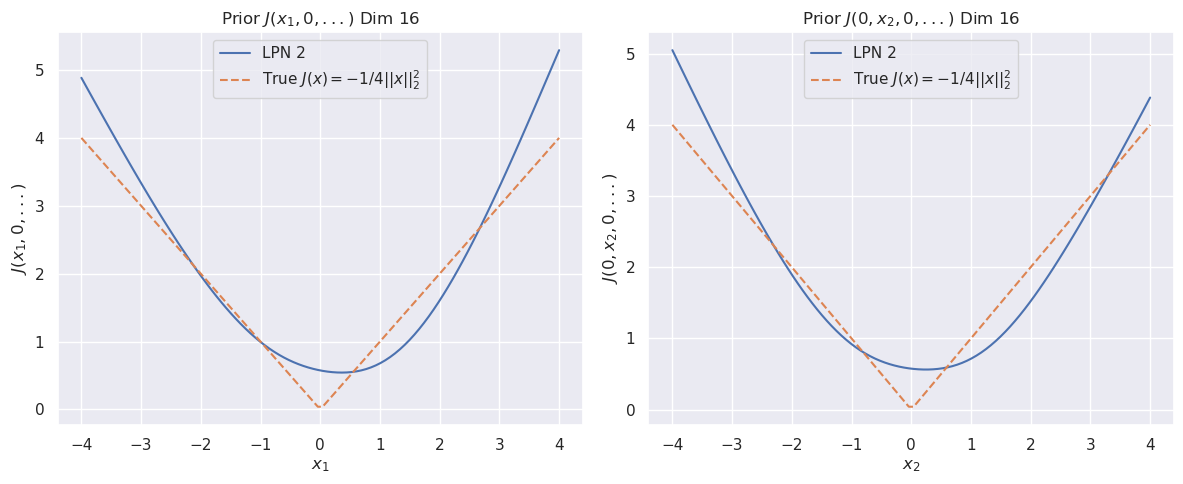

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_quadratic_l1(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_quadratic_l1(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)